<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/task_solve_v102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import random

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **NESTO**

In [3]:
imgs_dir='/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_comb/'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)

369

In [4]:
all_dirs.sort()

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def shuffle_split(all_dirs, val_pct=0.15, seed=99):
    seed_everything(seed)
    n_val = int(len(all_dirs) * val_pct)
    idx = np.random.permutation(len(all_dirs))
    all_dirs = np.array(all_dirs)[idx]
    return all_dirs[n_val:], all_dirs[:n_val]

In [6]:
seed_everything(1)
train_dirs, valid_dirs = shuffle_split(all_dirs)
print(len(valid_dirs), len(train_dirs))

55 314


In [7]:
class BratsDataset(Dataset):
    def __init__(self, img_dirs, modality_types, transform=None):
        self.img_dirs = img_dirs
        self.modality_types = modality_types
        self.transform = transform

    def __len__ (self):
        return len (self.img_dirs)

    def __getitem__(self, index):
        imgs_path = self.img_dirs[index]
        patient_id = os.path.basename(imgs_path)
        image = self.concat_imgs(imgs_path)

        mask = np.array(Image.open(f'{imgs_path}/{patient_id}_SEG_combined.jpg'))
        mask = (mask / 255 * 4).round()
        mask = self.preprocess_mask_labels(mask)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

         # Select only the first channel from the mask
        mask = mask[..., 0]
        return image.astype(float), mask.astype(float)

    ## Spajanje slika s id-om pacijenta
    def concat_imgs(self, path: str):
      patient_id = os.path.basename(path)
      types = []
      for modality_type in modality_types:
          img = np.array(Image.open(f'{path}/{patient_id}_{modality_type}_combined.jpg'))
          img = self.normalize(img)
          types.append(img)
      #return np.array(types)
      return np.array(types)[..., 0]

    ## Ova metoda pretvara izvornu masku segmentacije u one-hot kodiranu masku s četiri kanala koji predstavljaju različite regije tumora
    ## Cijeli tumor - WT, Tumorska jezgra - TC, Povećanje tumora - ET, Pozadina - BG
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1

        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1

        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        # mask = np.moveaxis(mask, (0, 1, 2), (0, 2, 1))
        return mask

    ## Normalizacija ulaznih podataka
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min
        return (data - data_min) / (np.max(data) - data_min)

modality_types = ['FLAIR', 'T1', 'T1CE', 'T2']

In [8]:
# Training transformations
trn_tfms = A.Compose([
    A.Resize(height=240, width=240),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
    ToTensorV2(),
])

# Validation transformations
val_tfms = A.Compose([
    A.Resize(height=240, width=240),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
    ToTensorV2(),
])

In [9]:
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
train_dl = DataLoader(train_ds, batch_size = 8, shuffle = True, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size = 8, shuffle = True, num_workers = 2, pin_memory = True)

torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])


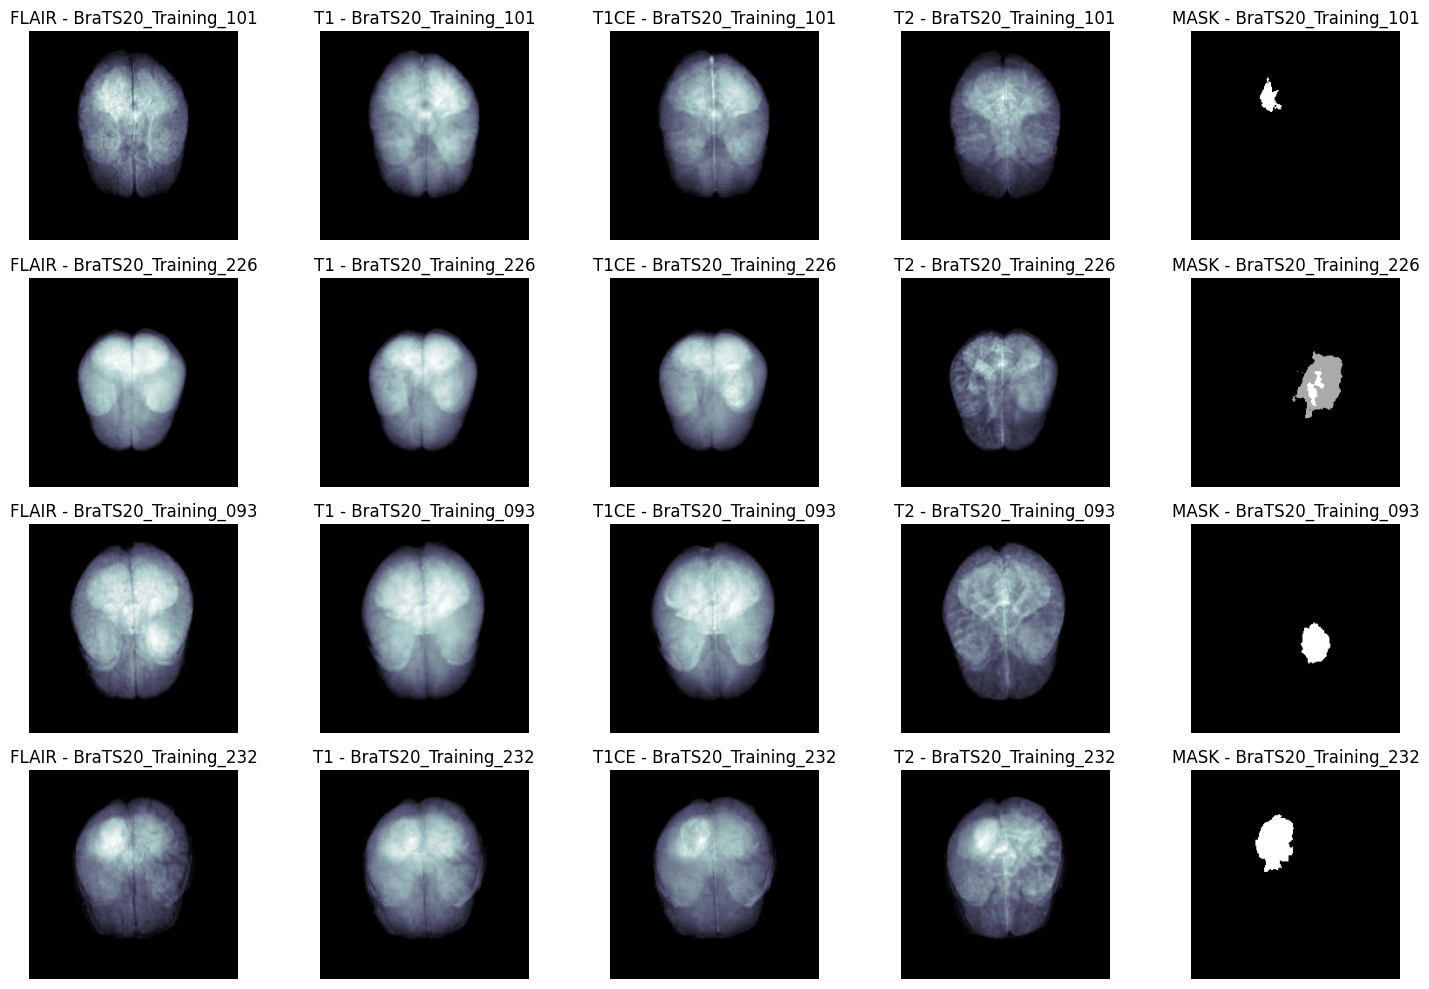

In [10]:
dl_it = iter(train_dl)

# Fetch and display information from the first few batches
for _ in range(4):
    imgs, msks = next(dl_it)
    print(imgs.shape)
    print(msks.shape)

# Shuffle the data
idx = np.random.permutation(imgs.shape[0])
imgs = imgs[idx]
msks = msks[idx]

plt.figure(figsize=(15, 10))
for i in range(4):
    patient_id = os.path.basename(train_ds.img_dirs[idx[i]])

    # Visualize the MRI modalities
    for j in range(len(modality_types)):
        plt.subplot(4, len(modality_types) + 1, (len(modality_types) + 1) * i + j + 1)
        plt.imshow(imgs[i][j], cmap='bone')
        plt.axis('off')
        plt.title(f"{modality_types[j]} - {patient_id}")

    # Visualize the segmentation mask
    plt.subplot(4, len(modality_types) + 1, (len(modality_types) + 1) * i + len(modality_types) + 1)
    plt.imshow(256 - (np.argmax(msks[i], axis=0) * 80), cmap='gray')
    plt.axis('off')
    plt.title(f"MASK - {patient_id}")

plt.tight_layout()
plt.show()

In [14]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, use_batchnorm=True):
        super(DoubleConv, self).__init__()

        if not mid_channels:
            mid_channels = out_channels

        # First Convolutional Block
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels) if use_batchnorm else None
        self.relu1 = nn.ReLU(inplace=True)

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels) if use_batchnorm else None
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        # First Convolutional Block
        x = self.conv1(x)
        if self.bn1:
            x = self.bn1(x)
        x = self.relu1(x)

        # Second Convolutional Block
        x = self.conv2(x)
        if self.bn2:
            x = self.bn2(x)
        x = self.relu2(x)

        return x


#ENKODER
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)


#DEKODER
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.activation = nn.Softmax() ##ovo je bio komentar
    def forward(self, x):
        return self.conv(x)
        # return self.activation(self.conv(x))
        x = self.conv(x)
        if self.activation:
            x = self.activation(x)
        return x

In [15]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [16]:
## Računa Dice koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti (probabilities) i stvarnih oznaka (truth)
## Dice koeficijent mjeri sličnost između predviđenih i stvarnih područja
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

## Računa Jaccard koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti i stvarnih oznaka
## Jaccard koeficijent mjeri sličnost između predviđenih i stvarnih područja
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


## Klasa koja služi za praćenje i ažuriranje Dice i Jaccard koeficijenata tijekom evaluacije modela
class Meter:
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

## Klasa koja implementira gubitak temeljen na Dice koeficijentu
class DiceLoss(nn.Module):
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score

## Klasa koja kombinira gubitak binarne unakrsne entropije (BCE) i gubitak temeljen na Dice koeficijentu
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)

        return bce_loss + dice_loss

## Pomoćne funkcije za test
## Računaju Dice i Jaccard koeficijente za svaku klasu u višeklasnoj segmentaciji
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET', 'BG']) -> np.ndarray:
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

In [17]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 val_dl: DataLoader,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : val_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        #print(f"{phase} epoch: {epoch + 1}/{self.num_epochs} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        # Zamijenite for petlju s tqdm
        for itr, (images, targets) in enumerate(tqdm(dataloader, desc=f"{phase} epoch {epoch + 1}/{self.num_epochs}")):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        print(f"Loss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f} | IoU: {epoch_iou:.4f}")
        return epoch_loss

    ## Pokretanje treniranja kroz sve epohe
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['pink', 'violet']  # Promijenjene boje
        labels = [
            f"Train Loss: {self.losses['train'][-1]:.4f} | Val Loss: {self.losses['val'][-1]:.4f}",
            f"Train Dice: {self.dice_scores['train'][-1]:.4f} | Val Dice: {self.dice_scores['val'][-1]:.4f}",
            f"Train Jaccard: {self.jaccard_scores['train'][-1]:.4f} | Val Jaccard: {self.jaccard_scores['val'][-1]:.4f}"
        ]

        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="Validation")
                ax.plot(data[i]['train'], c=colors[1], label="Training")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()


    ## Učitava unaprijed trenirani model iz pohranjenih težina
    def load_predtrain_model(self, state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")

    ## Spremanje težine modela i rezultate treniranja
    def _save_train_history(self):
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)


In [18]:
batch_size = 8
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)

print(len(valid_dl ), len(train_dl))

7 40


In [19]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=4, n_classes=4, bilinear=True).to(device).float()
#model = UNet(n_channels=4, n_classes=4).to(device)

In [20]:
trainer = Trainer(net = model,
                  train_dl = train_dl,
                  val_dl = valid_dl,
                  criterion = BCEDiceLoss(),
                  lr = 5e-4,
                  accumulation_steps = batch_size,
                  batch_size = batch_size,
                  num_epochs = 50,
                 )

device: cuda


train epoch 1/50: 100%|██████████| 40/40 [04:13<00:00,  6.34s/it]


Loss: 1.0501 | Dice: 0.8149 | IoU: 0.7212


val epoch 1/50: 100%|██████████| 7/7 [01:00<00:00,  8.60s/it]


Loss: 0.7855 | Dice: 0.9688 | IoU: 0.9403


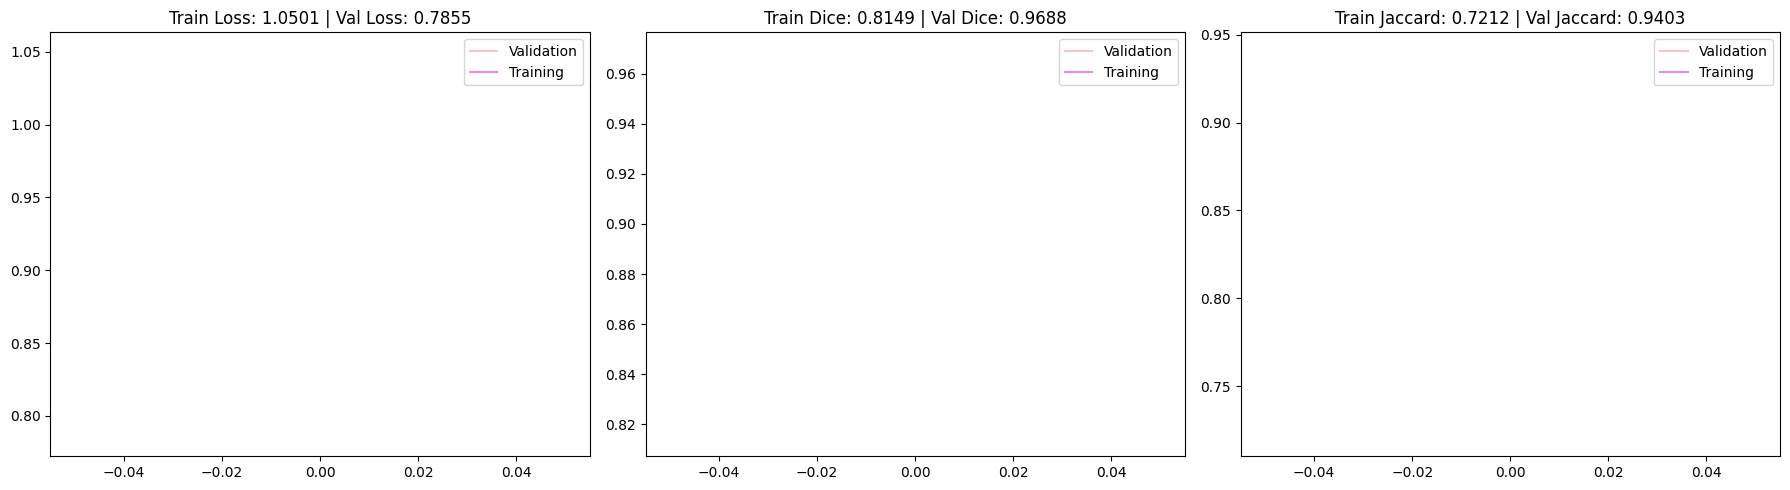


####################
Saved new checkpoint
####################




train epoch 2/50: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]


Loss: 0.7553 | Dice: 0.9754 | IoU: 0.9524


val epoch 2/50: 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]


Loss: 0.6475 | Dice: 0.9774 | IoU: 0.9561


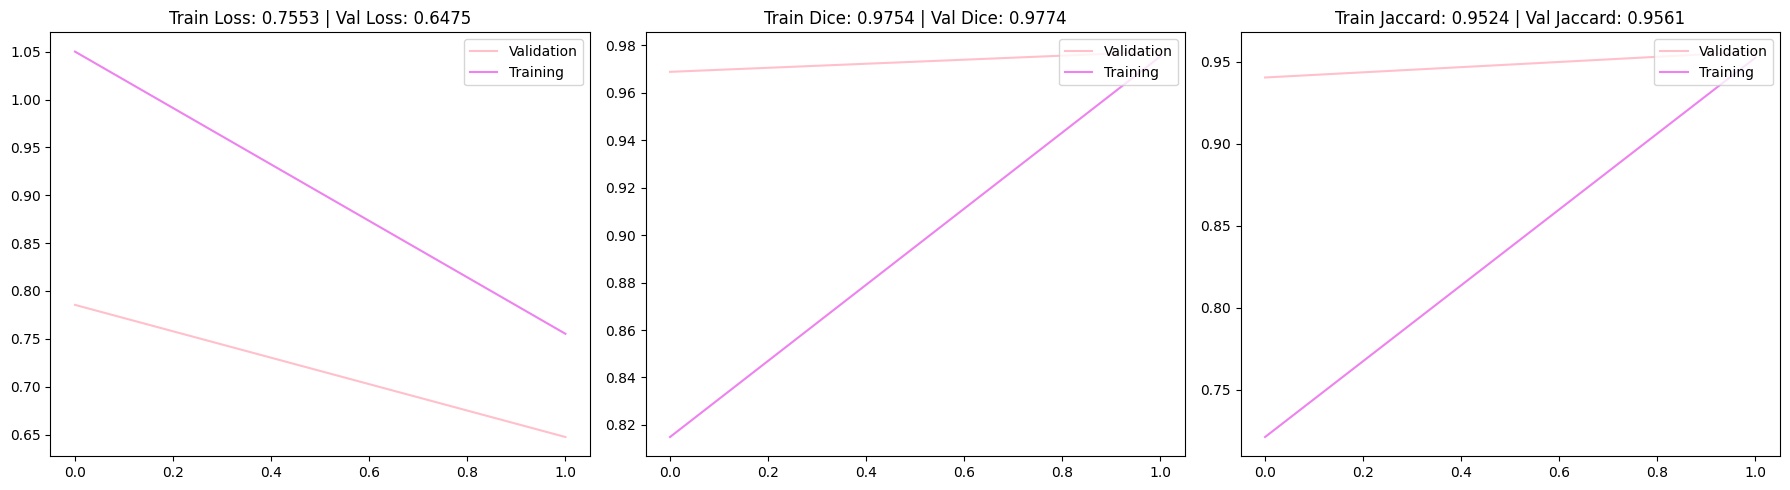


####################
Saved new checkpoint
####################




train epoch 3/50: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Loss: 0.5333 | Dice: 0.9798 | IoU: 0.9607


val epoch 3/50: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


Loss: 0.4834 | Dice: 0.9796 | IoU: 0.9605


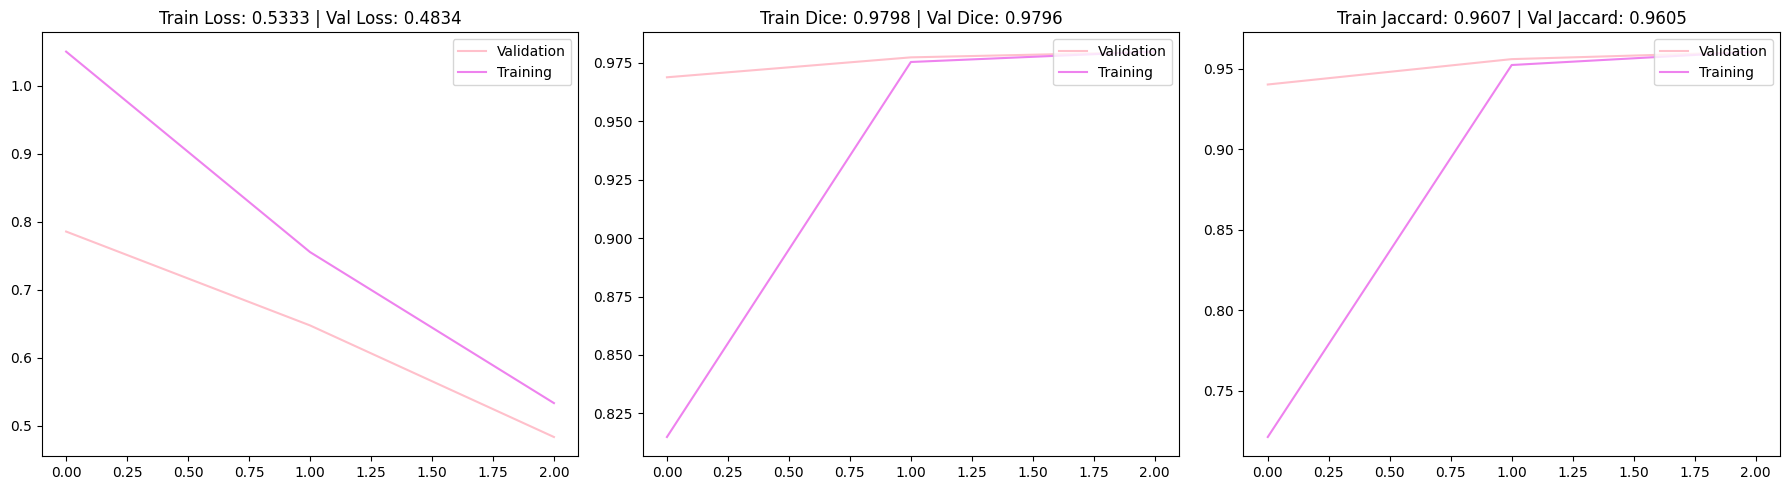


####################
Saved new checkpoint
####################




train epoch 4/50: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]


Loss: 0.3590 | Dice: 0.9833 | IoU: 0.9674


val epoch 4/50: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Loss: 0.3120 | Dice: 0.9820 | IoU: 0.9650


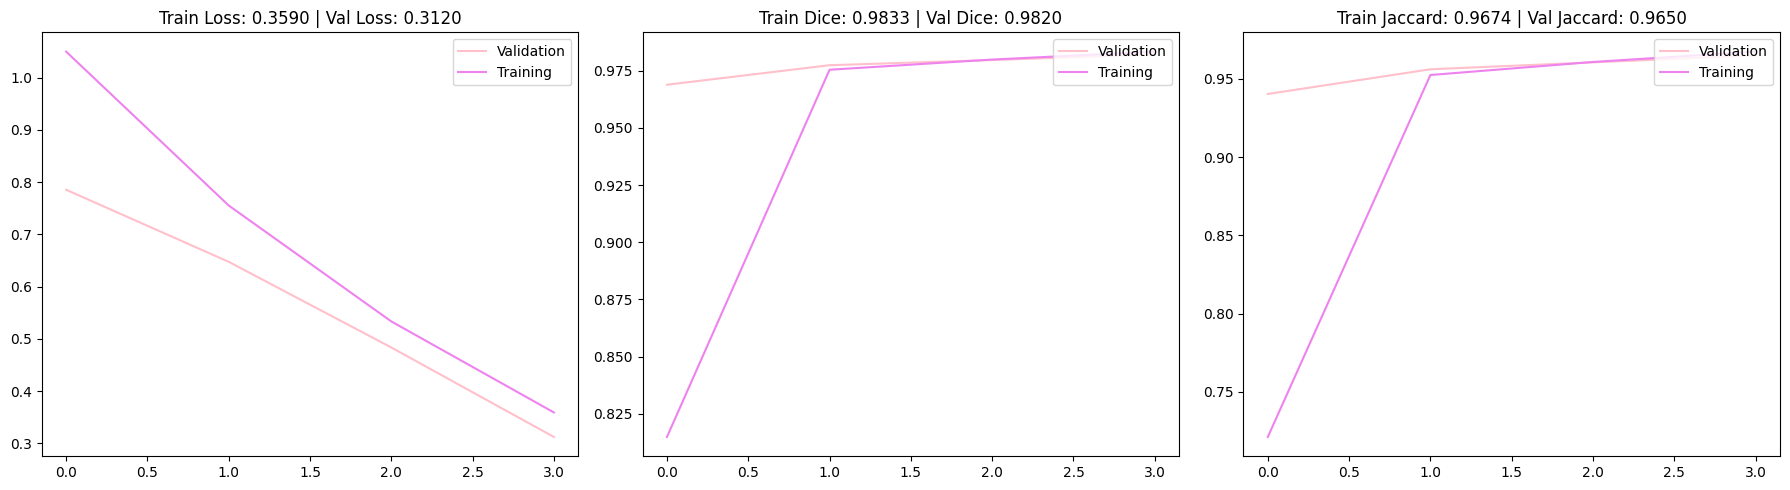


####################
Saved new checkpoint
####################




train epoch 5/50: 100%|██████████| 40/40 [00:16<00:00,  2.46it/s]


Loss: 0.2453 | Dice: 0.9836 | IoU: 0.9679


val epoch 5/50: 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]


Loss: 0.2069 | Dice: 0.9851 | IoU: 0.9709


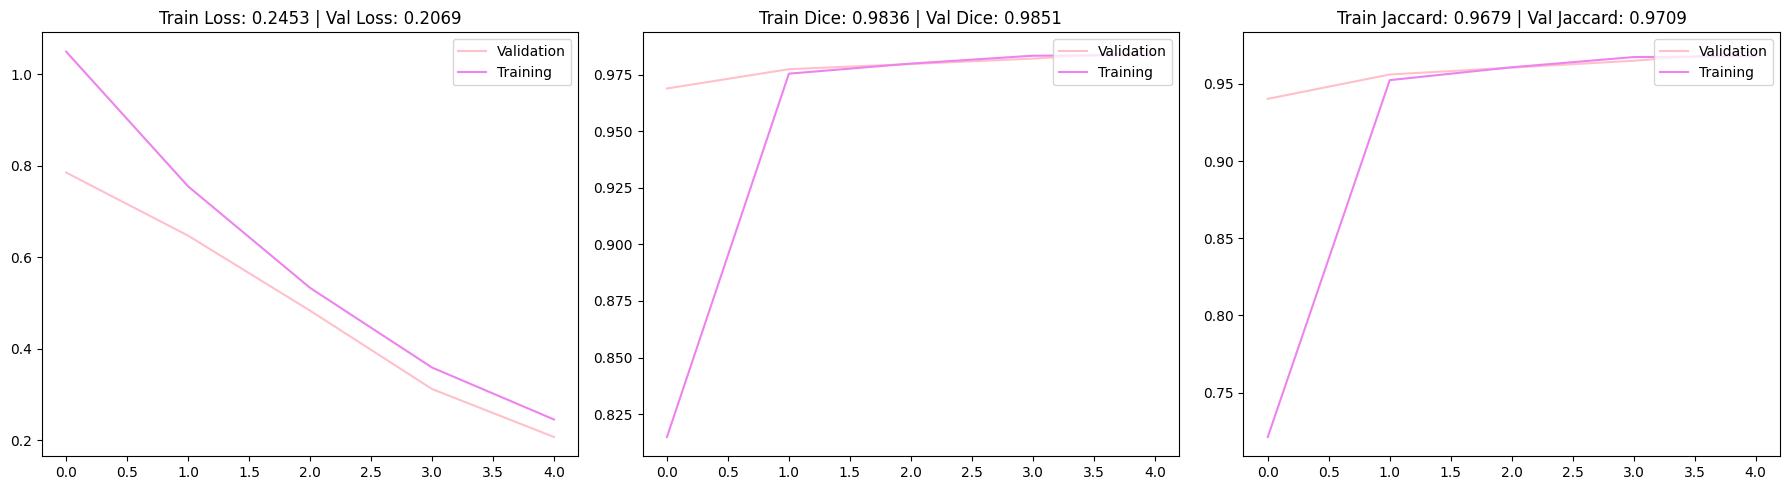


####################
Saved new checkpoint
####################




train epoch 6/50: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


Loss: 0.1757 | Dice: 0.9849 | IoU: 0.9704


val epoch 6/50: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


Loss: 0.1669 | Dice: 0.9818 | IoU: 0.9648


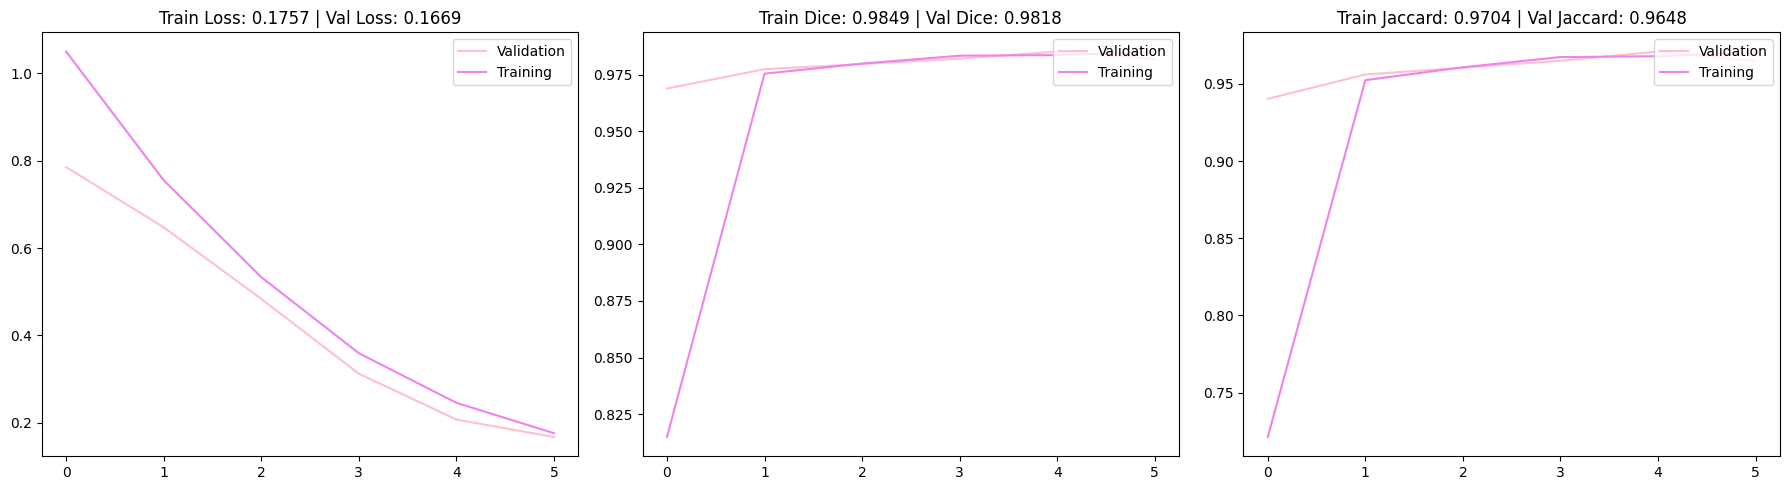


####################
Saved new checkpoint
####################




train epoch 7/50: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s]


Loss: 0.1371 | Dice: 0.9842 | IoU: 0.9692


val epoch 7/50: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


Loss: 0.1503 | Dice: 0.9722 | IoU: 0.9463


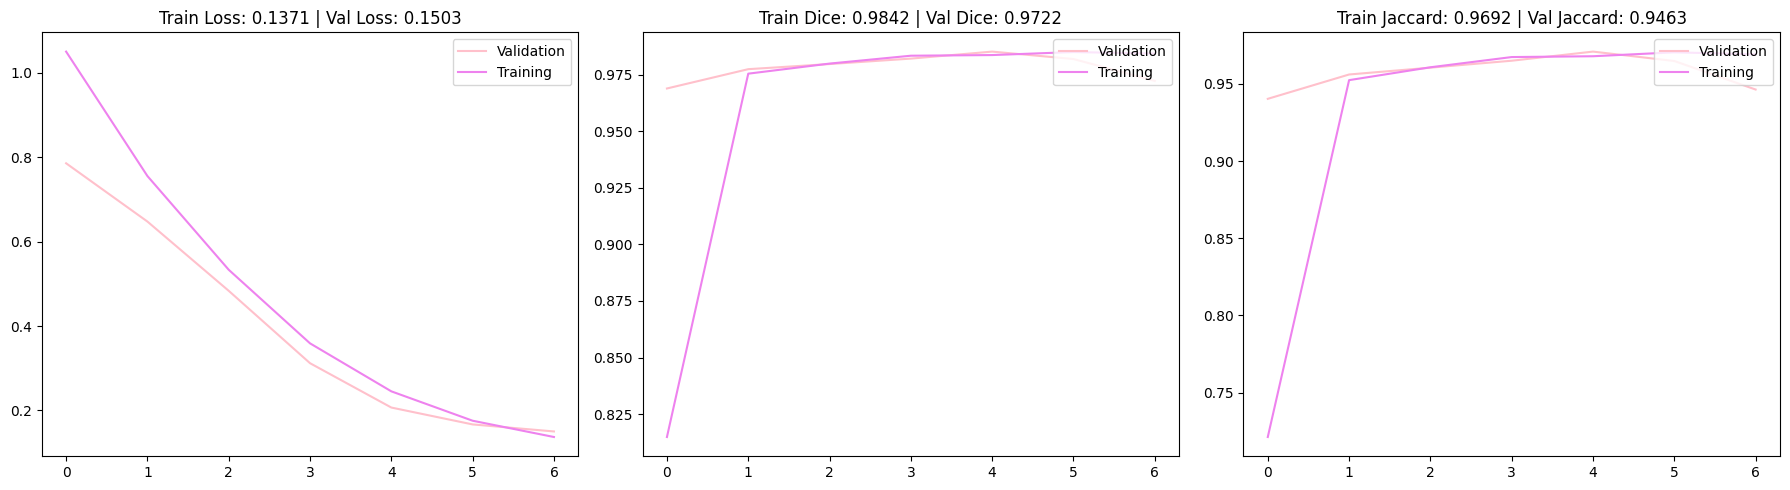


####################
Saved new checkpoint
####################




train epoch 8/50: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


Loss: 0.1098 | Dice: 0.9853 | IoU: 0.9711


val epoch 8/50: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]


Loss: 0.1033 | Dice: 0.9852 | IoU: 0.9712


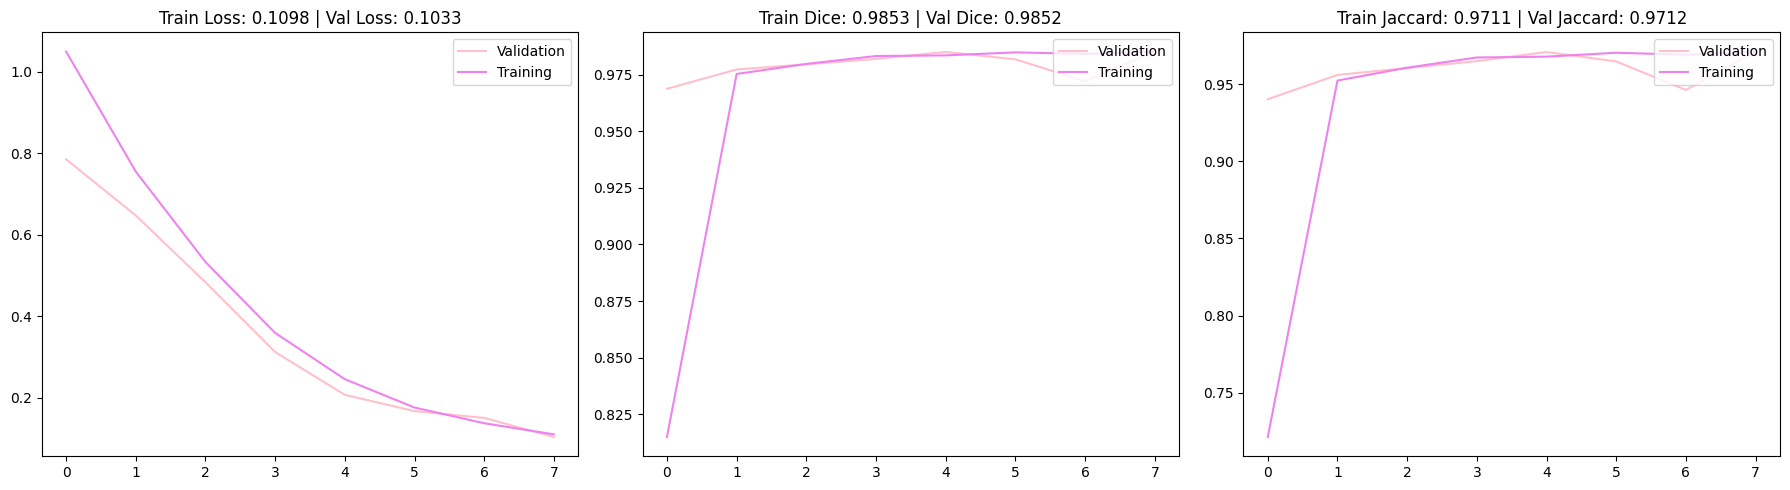


####################
Saved new checkpoint
####################




train epoch 9/50: 100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Loss: 0.0912 | Dice: 0.9862 | IoU: 0.9730


val epoch 9/50: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


Loss: 0.0955 | Dice: 0.9837 | IoU: 0.9681


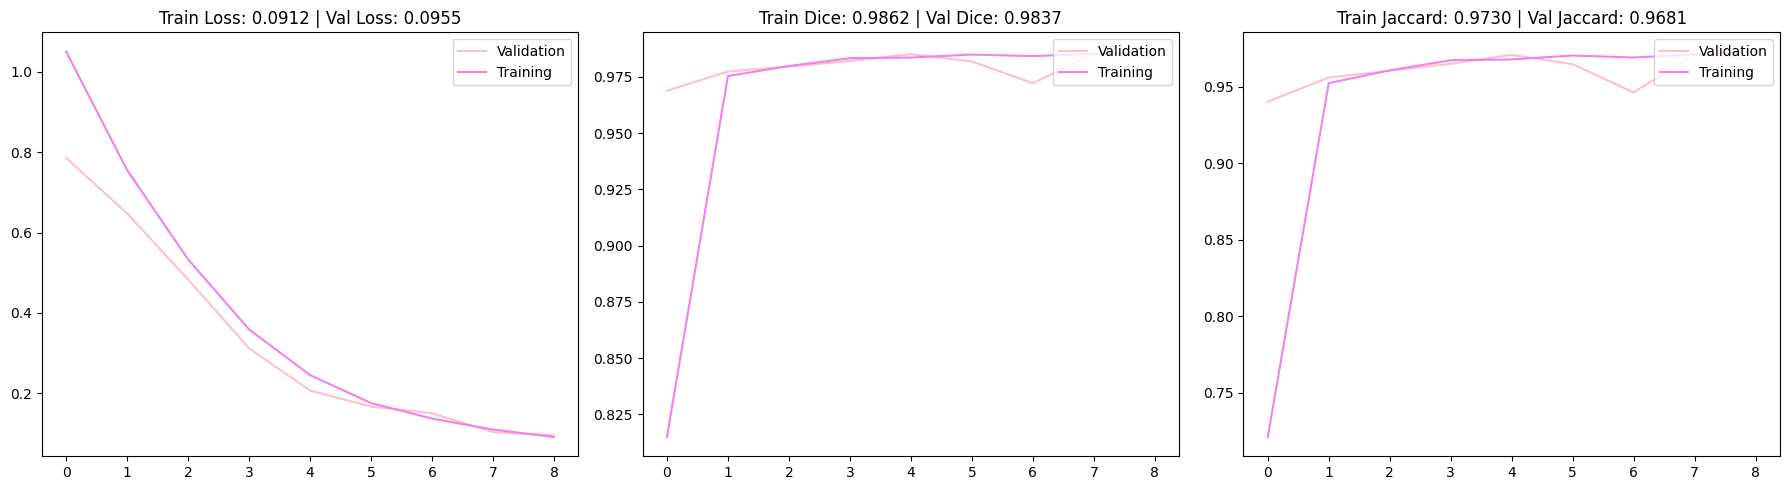


####################
Saved new checkpoint
####################




train epoch 10/50: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s]


Loss: 0.0792 | Dice: 0.9860 | IoU: 0.9726


val epoch 10/50: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]


Loss: 0.0740 | Dice: 0.9851 | IoU: 0.9710


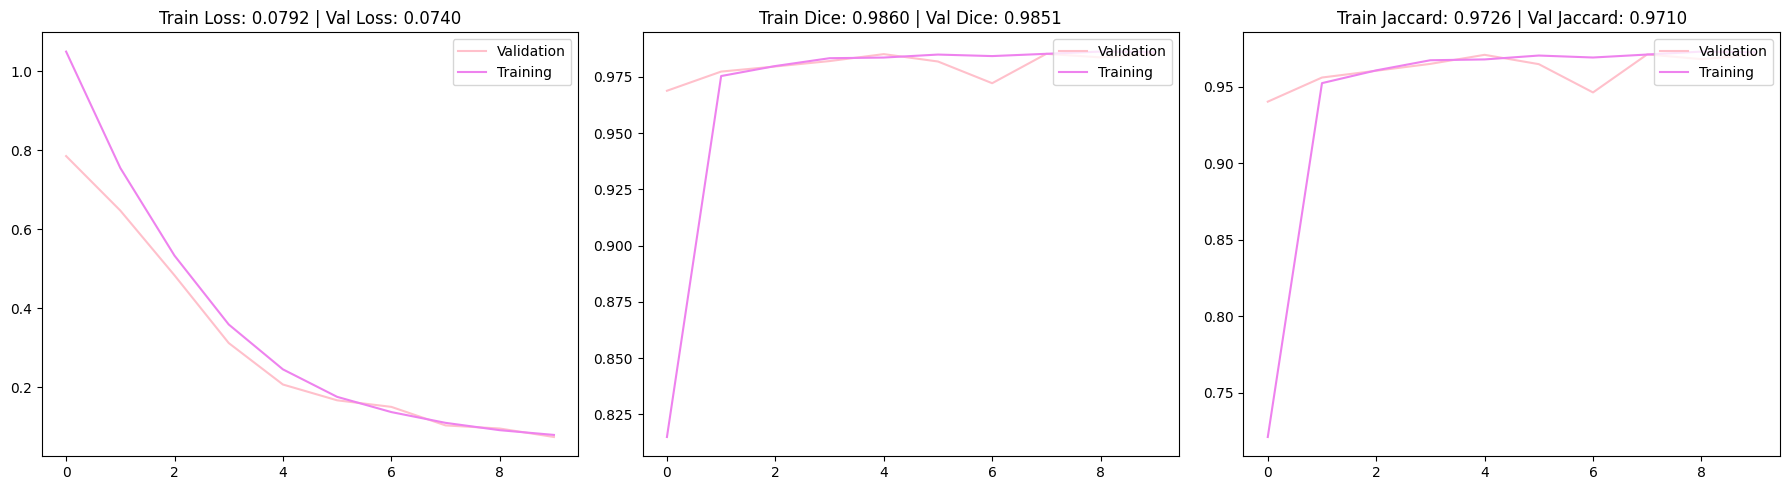


####################
Saved new checkpoint
####################




train epoch 11/50: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Loss: 0.0711 | Dice: 0.9860 | IoU: 0.9726


val epoch 11/50: 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]


Loss: 0.0693 | Dice: 0.9848 | IoU: 0.9703


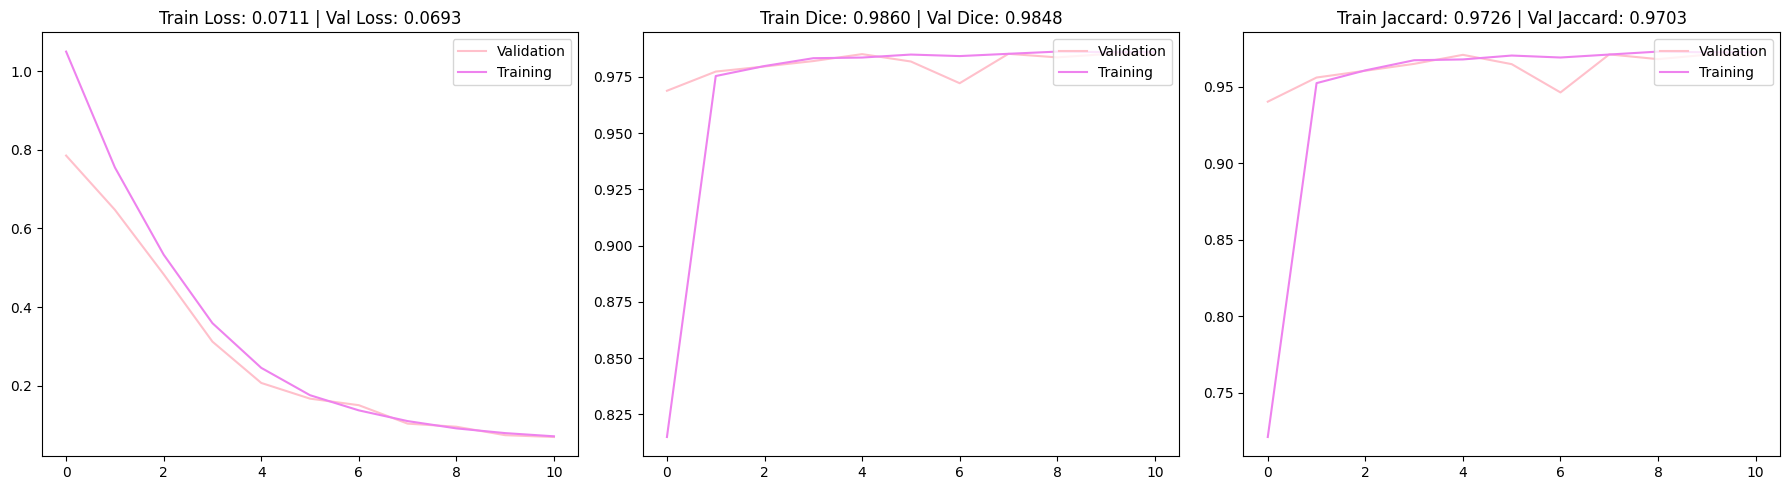


####################
Saved new checkpoint
####################




train epoch 12/50: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


Loss: 0.0655 | Dice: 0.9857 | IoU: 0.9719


val epoch 12/50: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


Loss: 0.0638 | Dice: 0.9857 | IoU: 0.9720


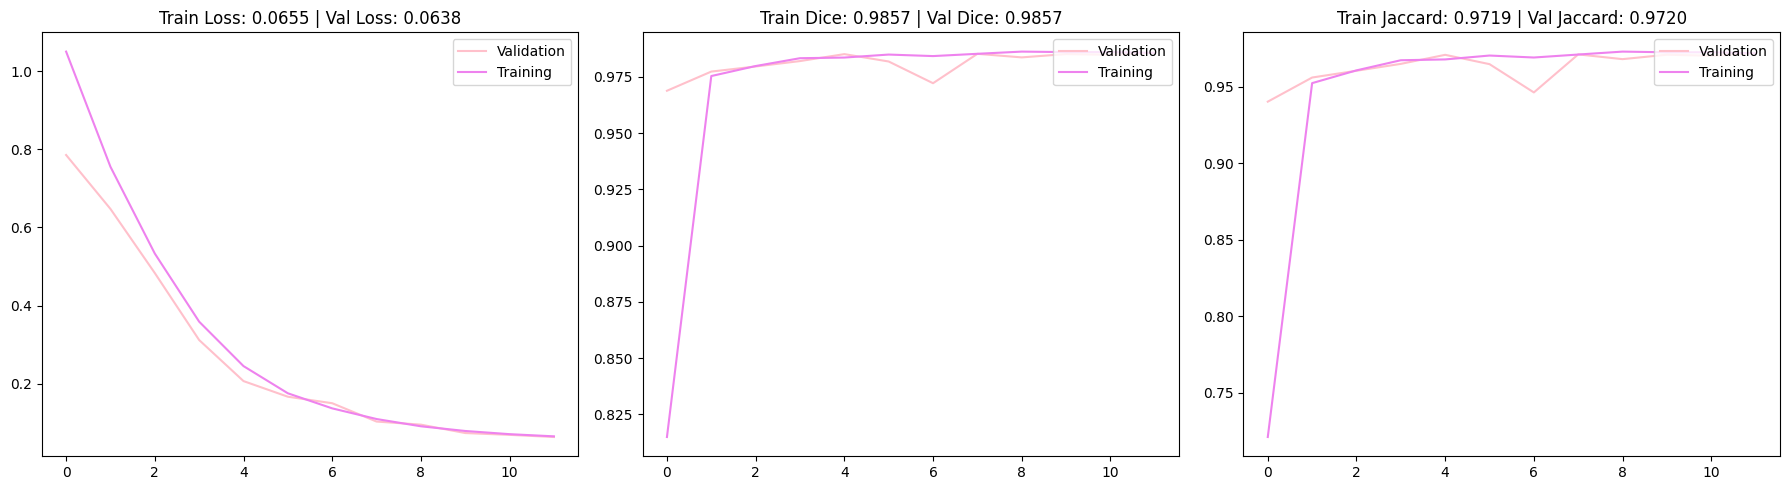


####################
Saved new checkpoint
####################




train epoch 13/50: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


Loss: 0.0600 | Dice: 0.9858 | IoU: 0.9722


val epoch 13/50: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Loss: 0.0630 | Dice: 0.9844 | IoU: 0.9696


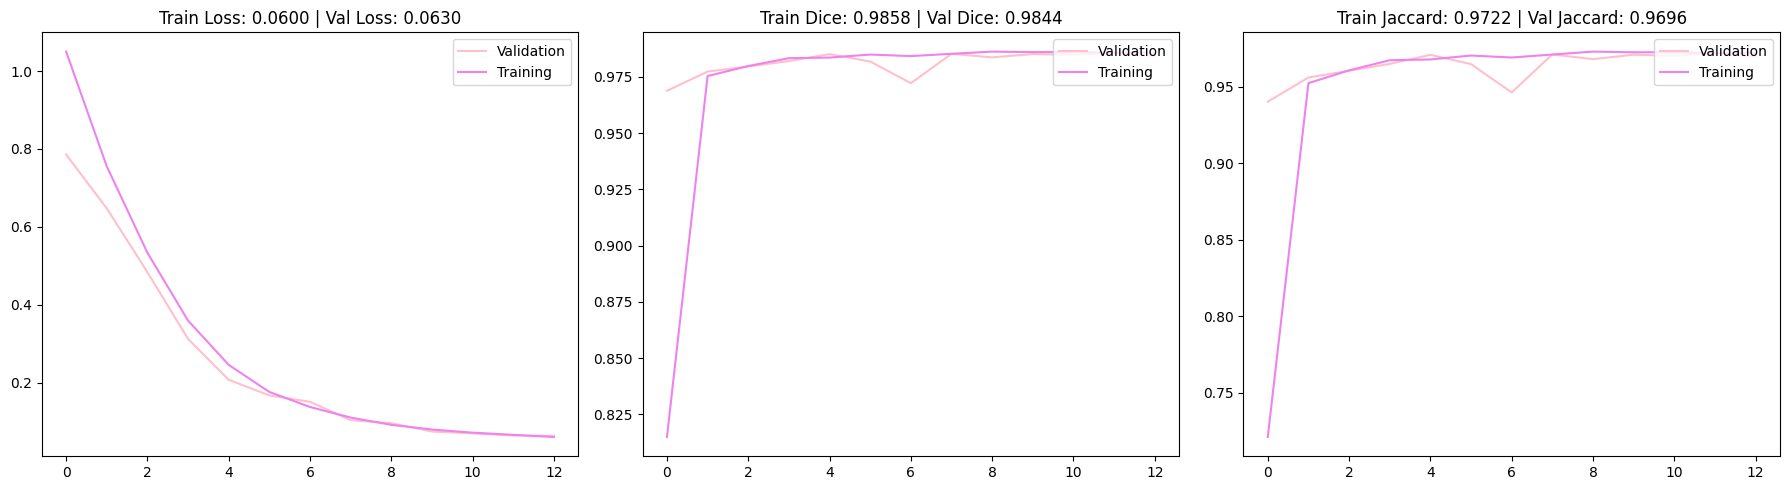


####################
Saved new checkpoint
####################




train epoch 14/50: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Loss: 0.0567 | Dice: 0.9858 | IoU: 0.9722


val epoch 14/50: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]


Loss: 0.0732 | Dice: 0.9794 | IoU: 0.9601


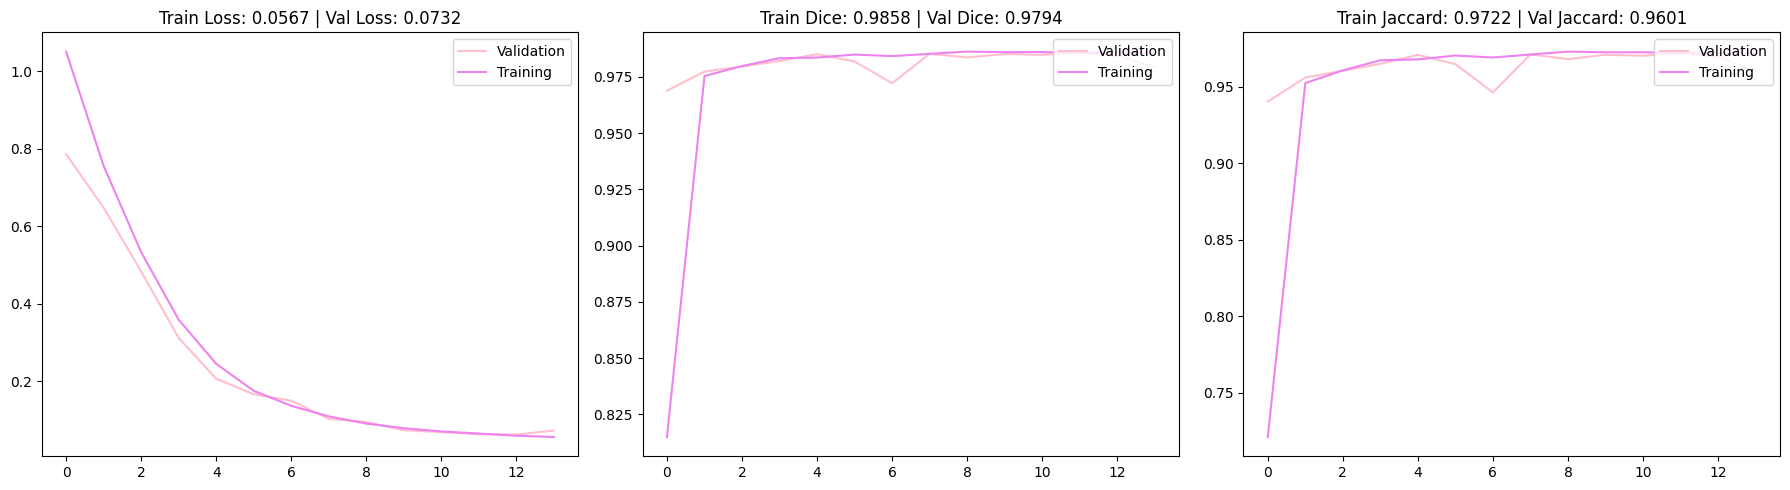

train epoch 15/50: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


Loss: 0.0522 | Dice: 0.9867 | IoU: 0.9738


val epoch 15/50: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


Loss: 0.0498 | Dice: 0.9857 | IoU: 0.9721


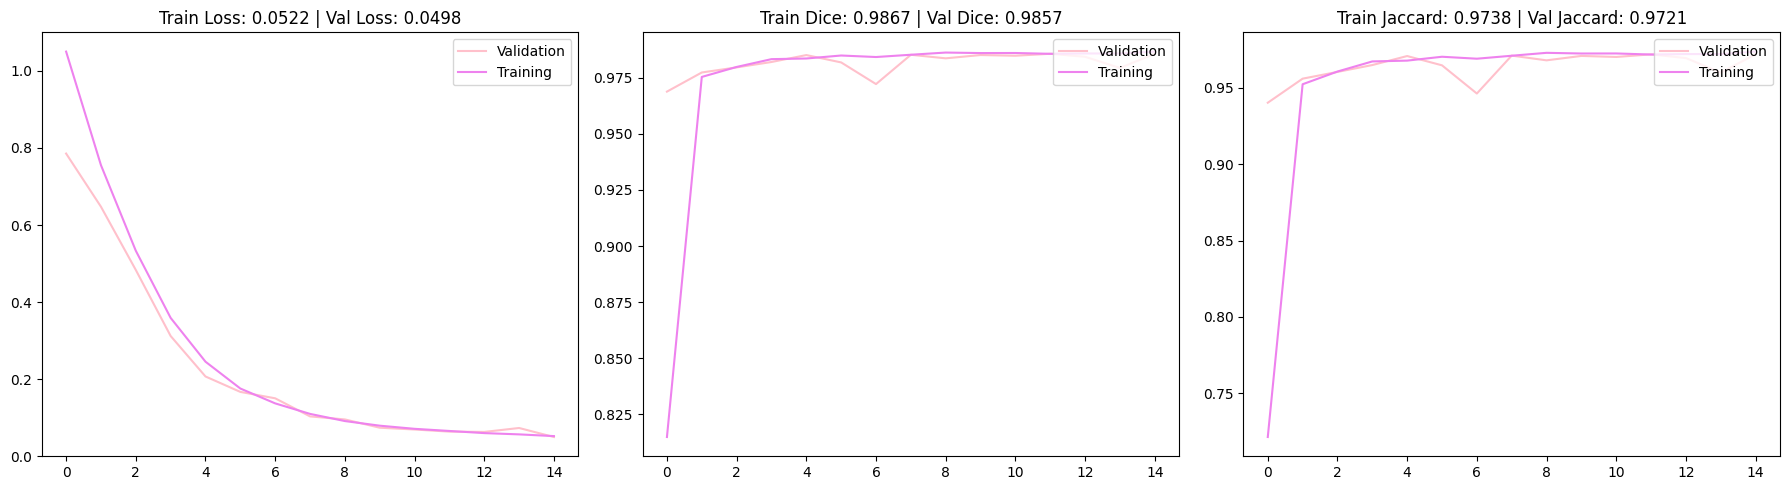


####################
Saved new checkpoint
####################




train epoch 16/50: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


Loss: 0.0490 | Dice: 0.9871 | IoU: 0.9746


val epoch 16/50: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Loss: 0.0487 | Dice: 0.9866 | IoU: 0.9738


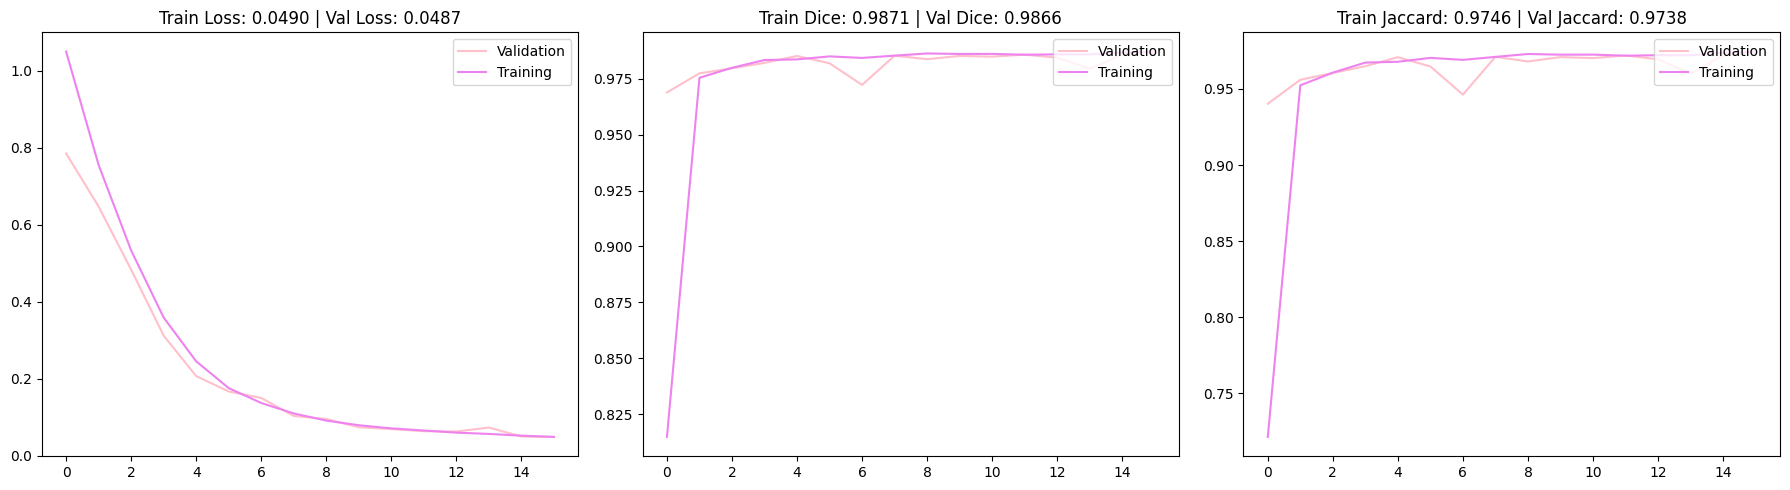


####################
Saved new checkpoint
####################




train epoch 17/50: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


Loss: 0.0481 | Dice: 0.9866 | IoU: 0.9738


val epoch 17/50: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]


Loss: 0.0586 | Dice: 0.9820 | IoU: 0.9651


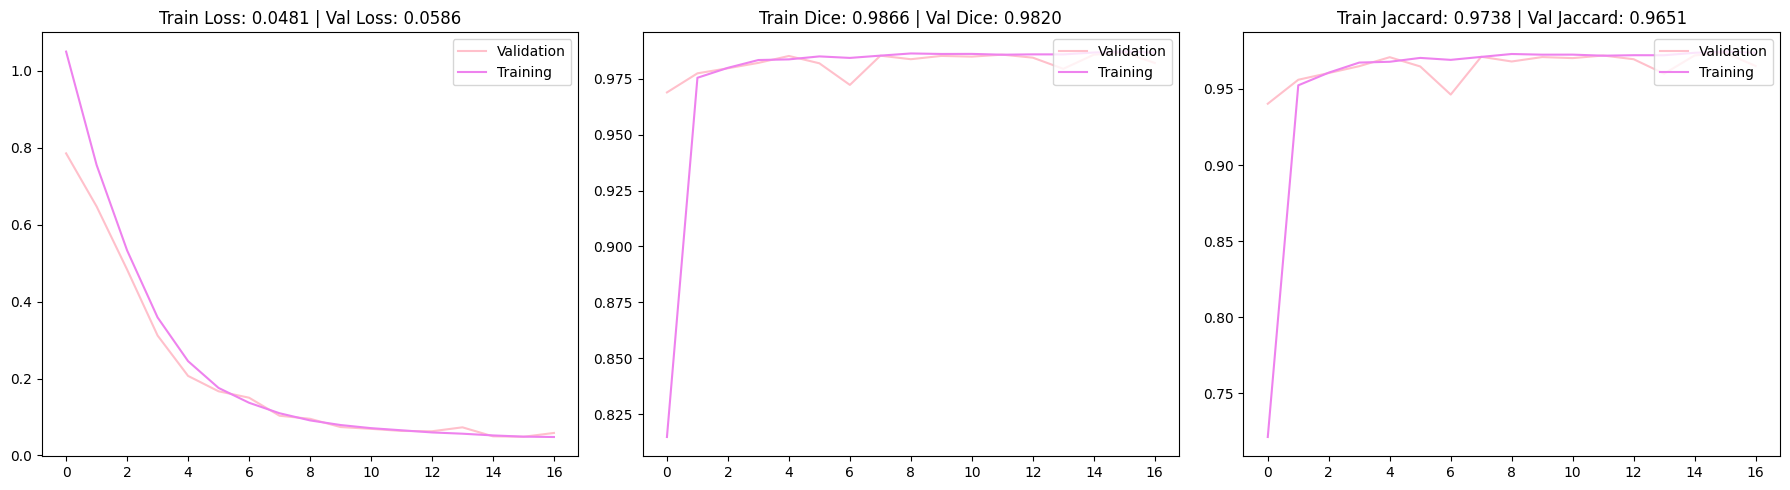

train epoch 18/50: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s]


Loss: 0.0467 | Dice: 0.9864 | IoU: 0.9734


val epoch 18/50: 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]


Loss: 0.0446 | Dice: 0.9873 | IoU: 0.9752


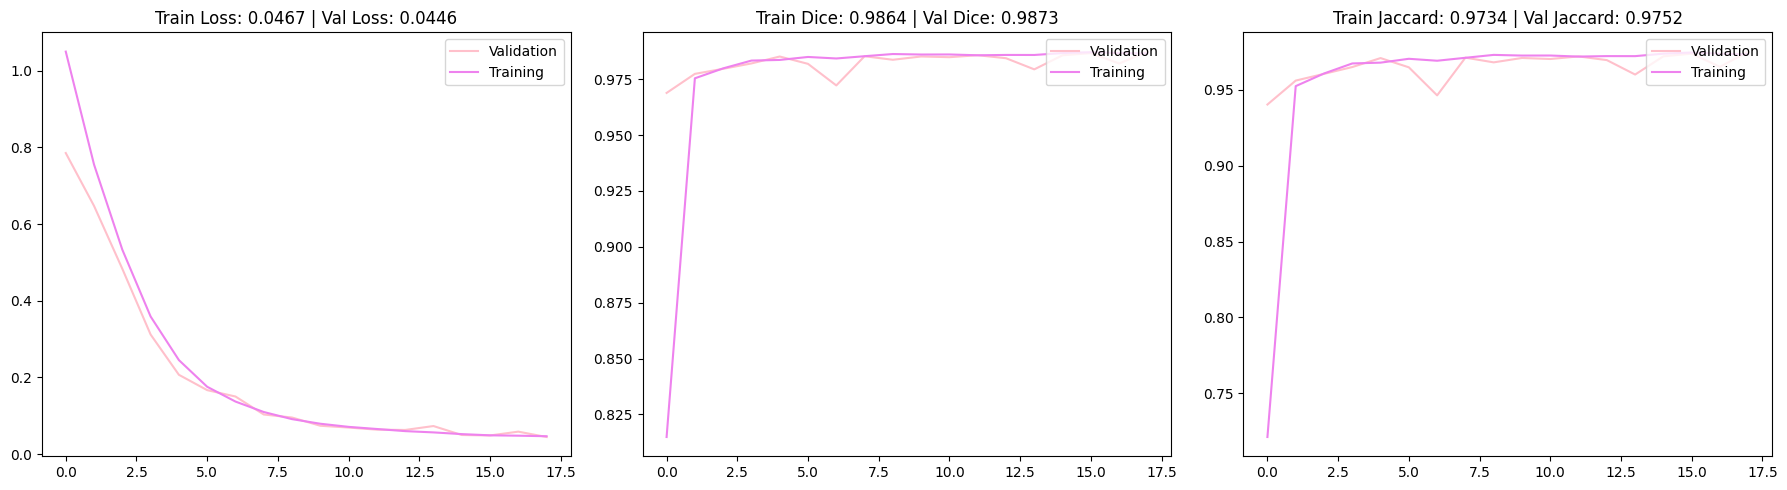


####################
Saved new checkpoint
####################




train epoch 19/50: 100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Loss: 0.0428 | Dice: 0.9875 | IoU: 0.9754


val epoch 19/50: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Loss: 0.0482 | Dice: 0.9857 | IoU: 0.9720


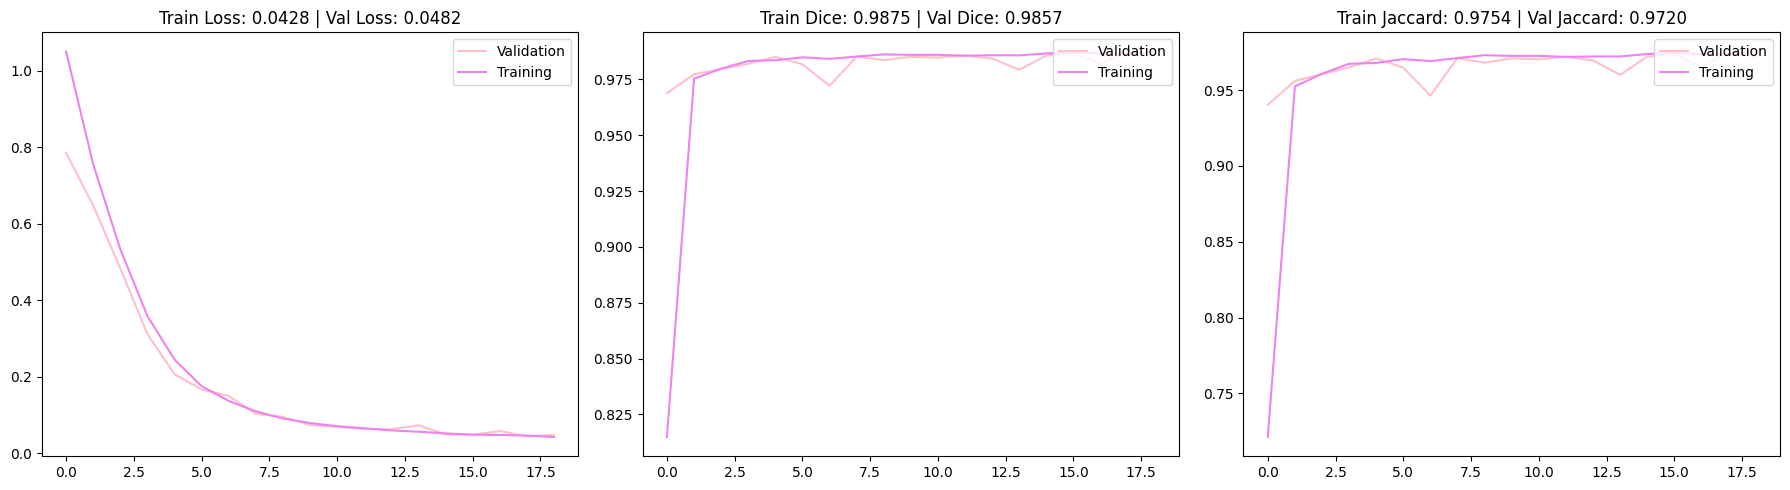

train epoch 20/50: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


Loss: 0.0448 | Dice: 0.9863 | IoU: 0.9732


val epoch 20/50: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]


Loss: 0.0410 | Dice: 0.9877 | IoU: 0.9760


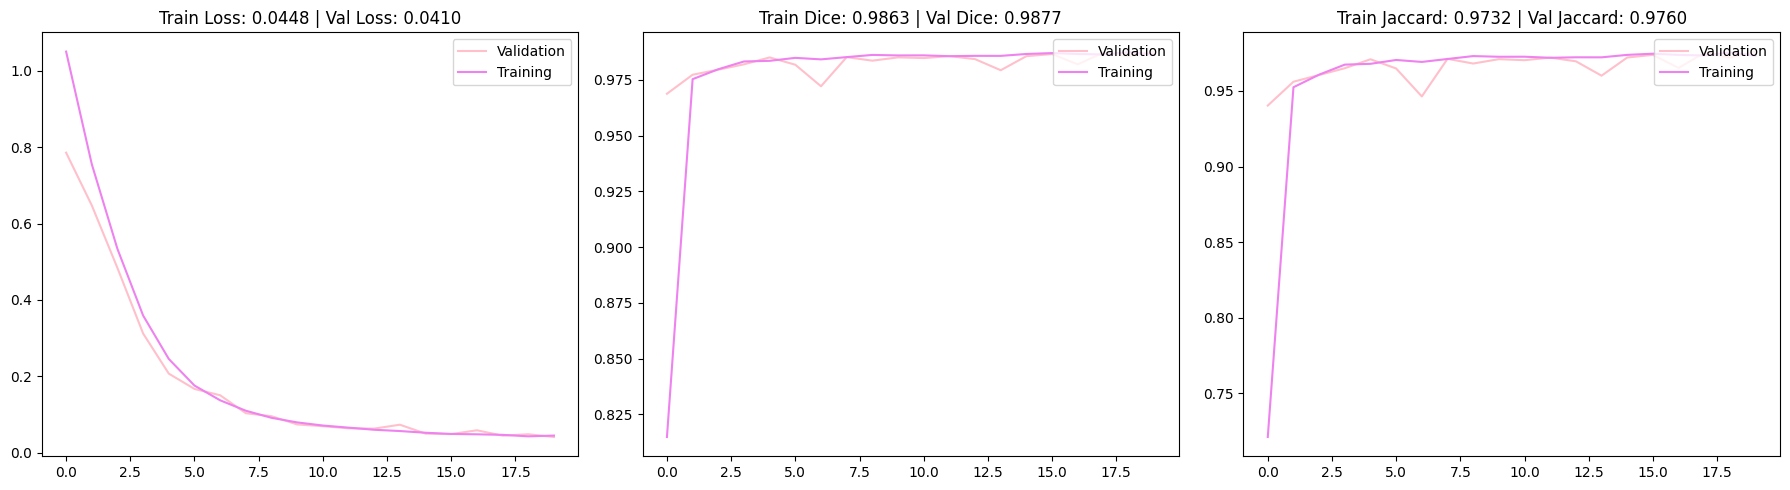


####################
Saved new checkpoint
####################




train epoch 21/50: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Loss: 0.0421 | Dice: 0.9872 | IoU: 0.9748


val epoch 21/50: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Loss: 0.0431 | Dice: 0.9870 | IoU: 0.9745


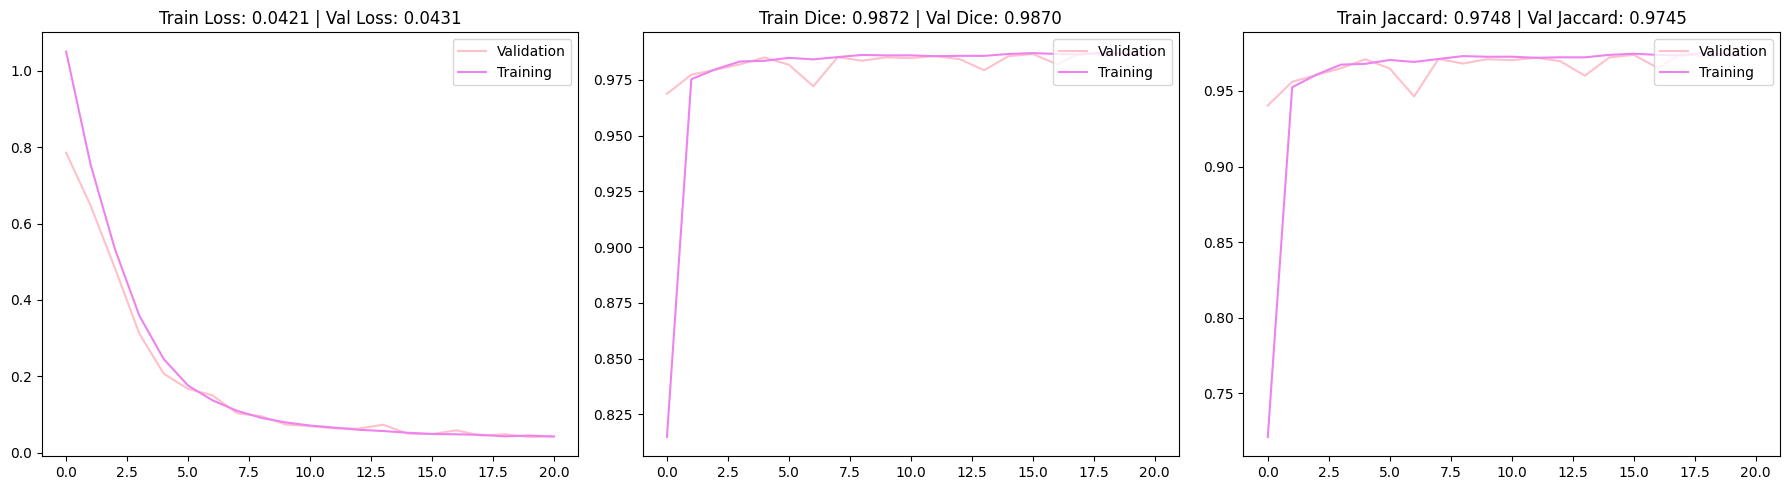

train epoch 22/50: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s]


Loss: 0.0413 | Dice: 0.9871 | IoU: 0.9746


val epoch 22/50: 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]


Loss: 0.0527 | Dice: 0.9818 | IoU: 0.9646


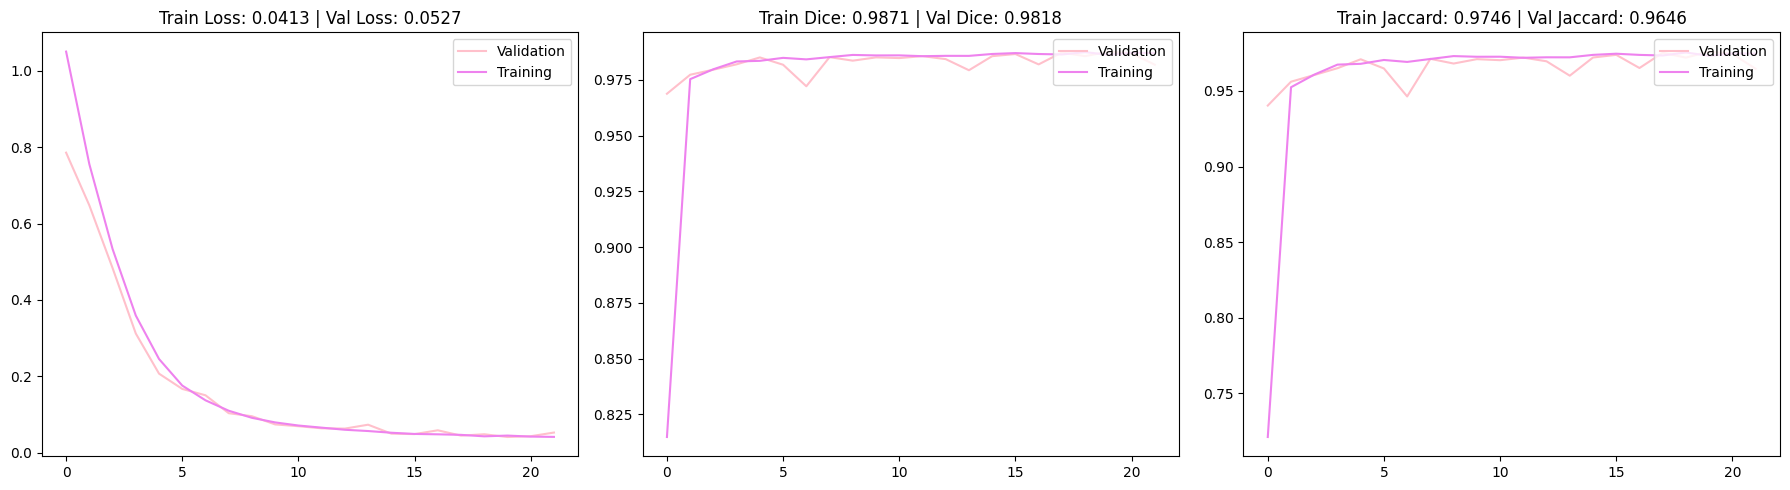

train epoch 23/50: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


Loss: 0.0410 | Dice: 0.9868 | IoU: 0.9741


val epoch 23/50: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Loss: 0.0559 | Dice: 0.9823 | IoU: 0.9656
Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.


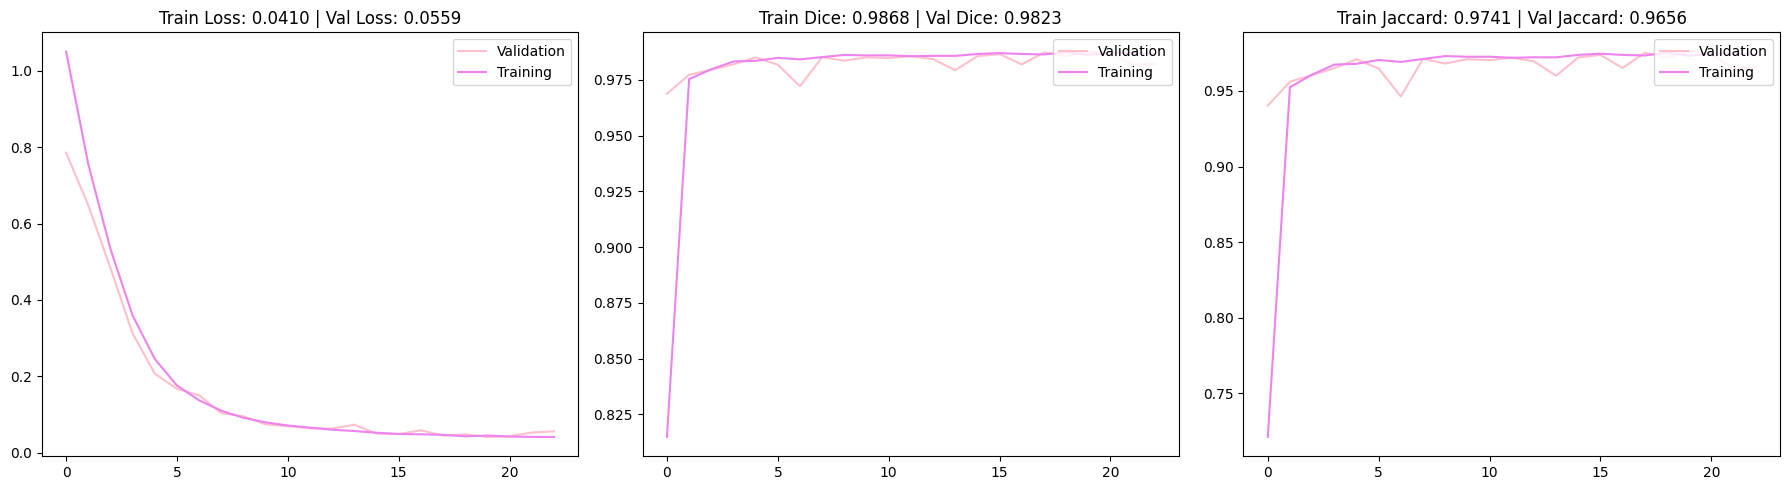

train epoch 24/50: 100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


Loss: 0.0381 | Dice: 0.9879 | IoU: 0.9761


val epoch 24/50: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


Loss: 0.0389 | Dice: 0.9879 | IoU: 0.9762


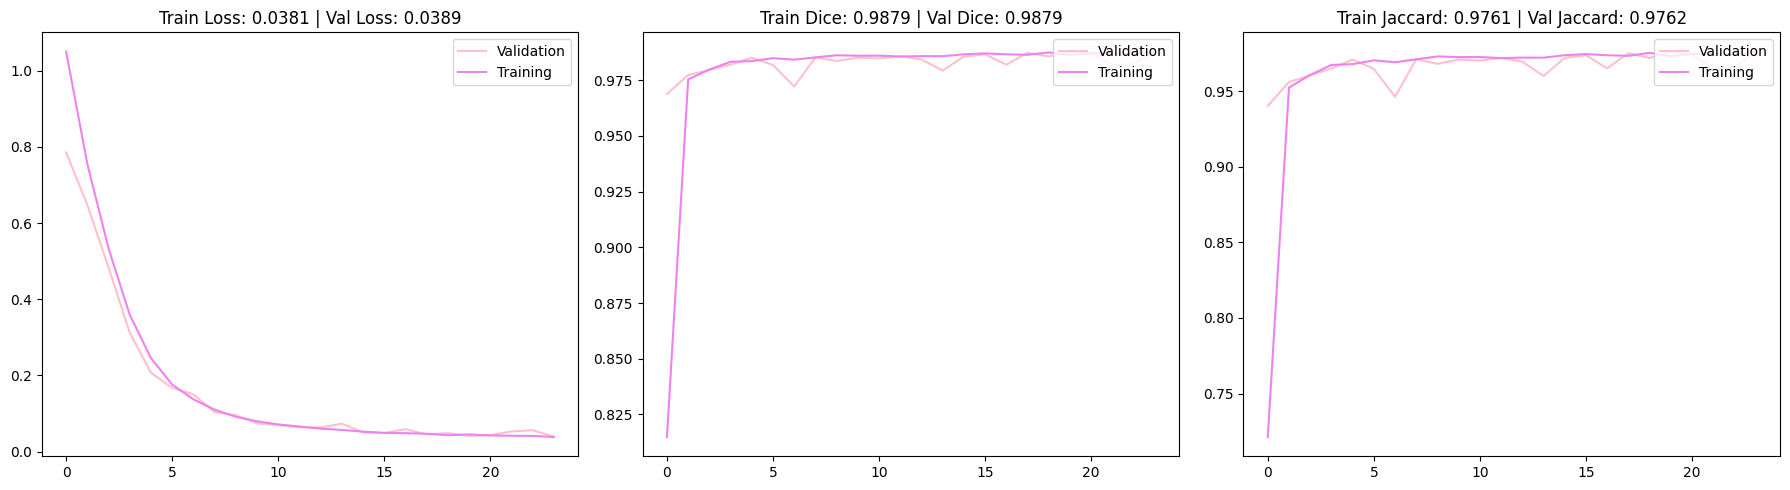


####################
Saved new checkpoint
####################




train epoch 25/50: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s]


Loss: 0.0361 | Dice: 0.9887 | IoU: 0.9778


val epoch 25/50: 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


Loss: 0.0393 | Dice: 0.9874 | IoU: 0.9753


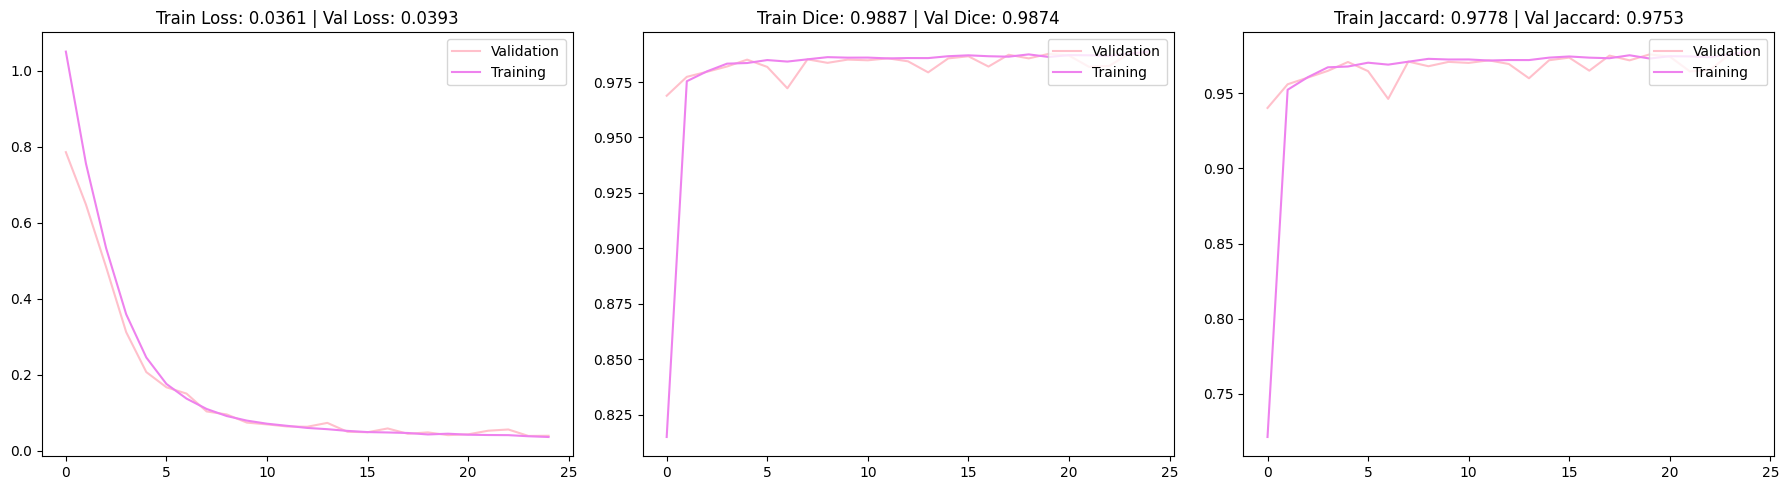

train epoch 26/50: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s]


Loss: 0.0364 | Dice: 0.9885 | IoU: 0.9773


val epoch 26/50: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


Loss: 0.0386 | Dice: 0.9876 | IoU: 0.9757


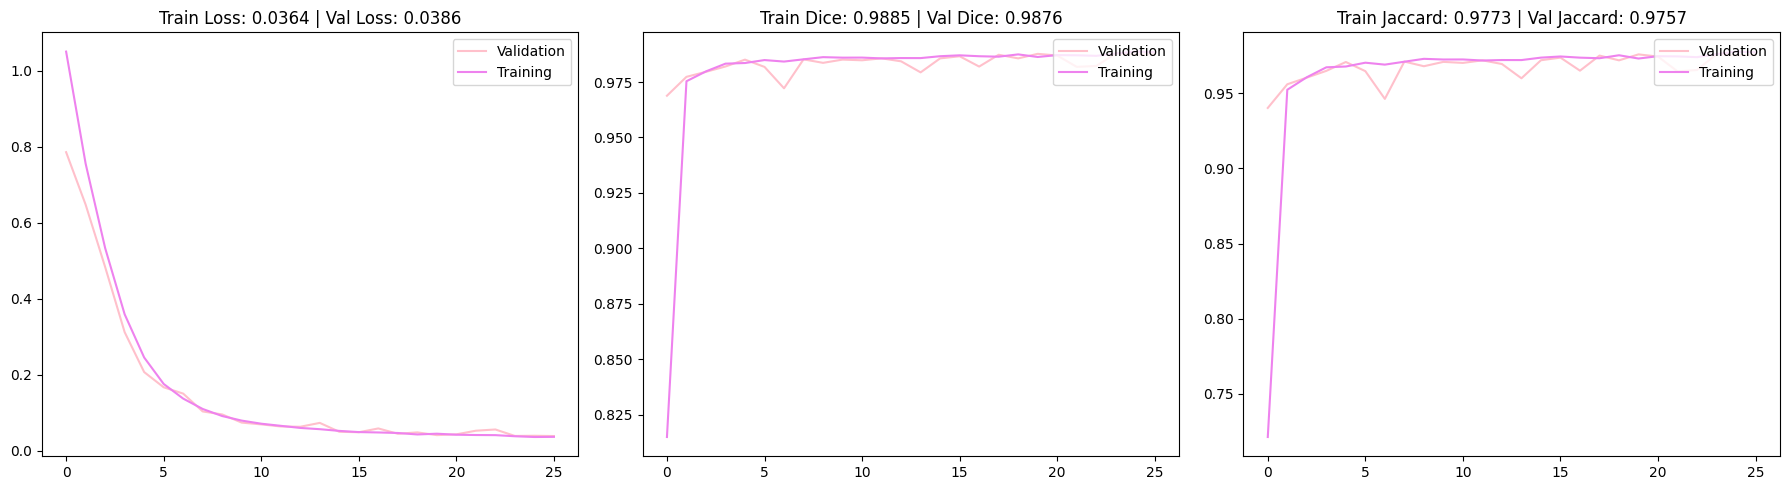


####################
Saved new checkpoint
####################




train epoch 27/50: 100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Loss: 0.0360 | Dice: 0.9886 | IoU: 0.9775


val epoch 27/50: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


Loss: 0.0380 | Dice: 0.9880 | IoU: 0.9764


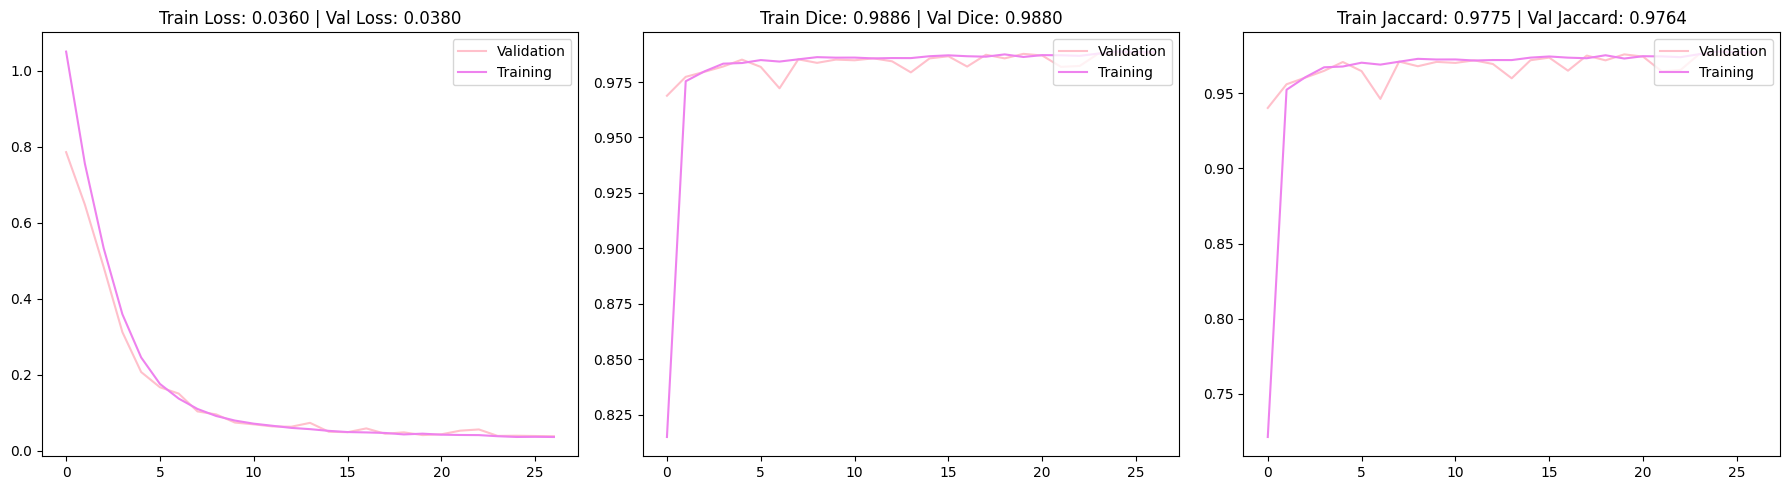


####################
Saved new checkpoint
####################




train epoch 28/50: 100%|██████████| 40/40 [00:16<00:00,  2.35it/s]


Loss: 0.0352 | Dice: 0.9889 | IoU: 0.9781


val epoch 28/50: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]


Loss: 0.0386 | Dice: 0.9876 | IoU: 0.9757


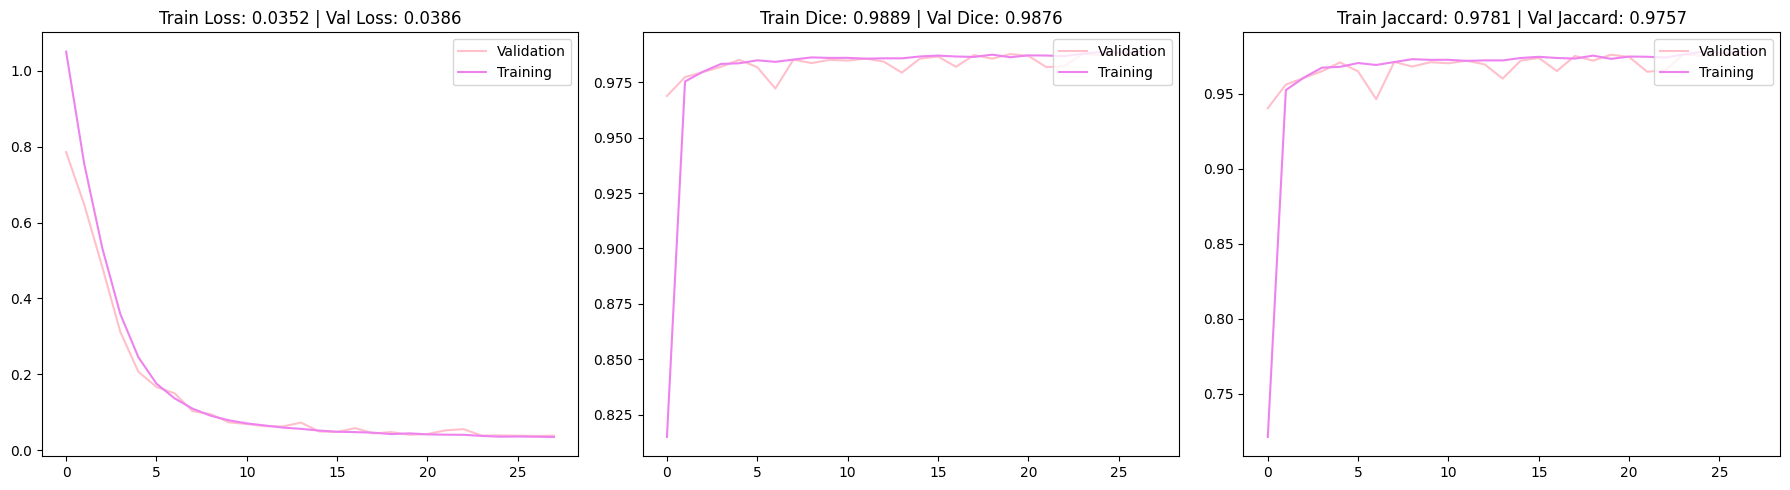

train epoch 29/50: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


Loss: 0.0351 | Dice: 0.9890 | IoU: 0.9783


val epoch 29/50: 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]


Loss: 0.0384 | Dice: 0.9876 | IoU: 0.9758


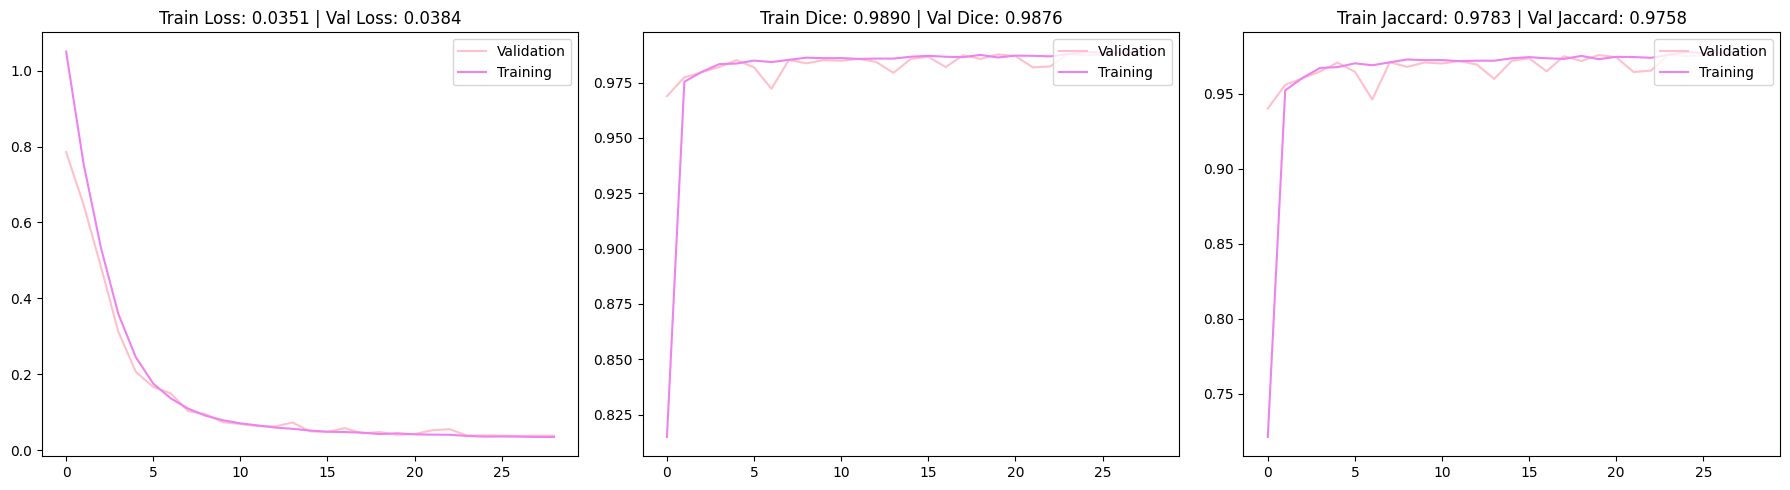

train epoch 30/50: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Loss: 0.0349 | Dice: 0.9890 | IoU: 0.9782


val epoch 30/50: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Loss: 0.0382 | Dice: 0.9879 | IoU: 0.9763
Epoch 00030: reducing learning rate of group 0 to 5.0000e-06.


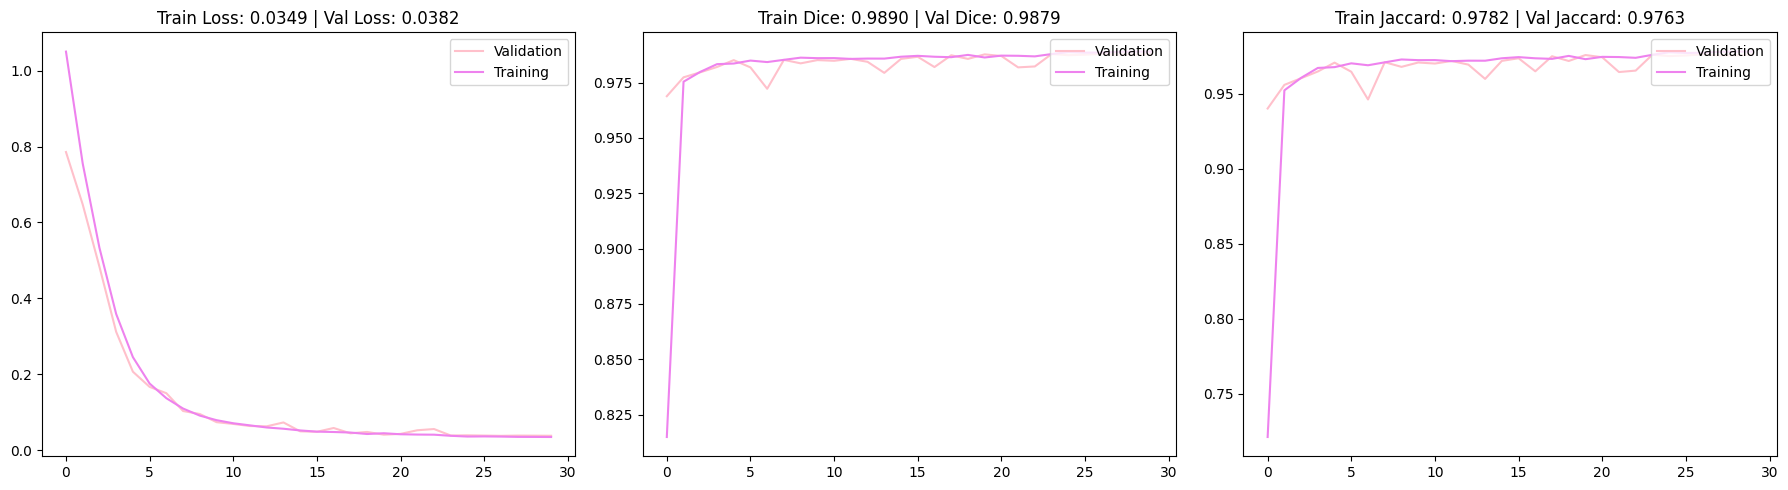

train epoch 31/50: 100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Loss: 0.0344 | Dice: 0.9892 | IoU: 0.9788


val epoch 31/50: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


Loss: 0.0385 | Dice: 0.9877 | IoU: 0.9759


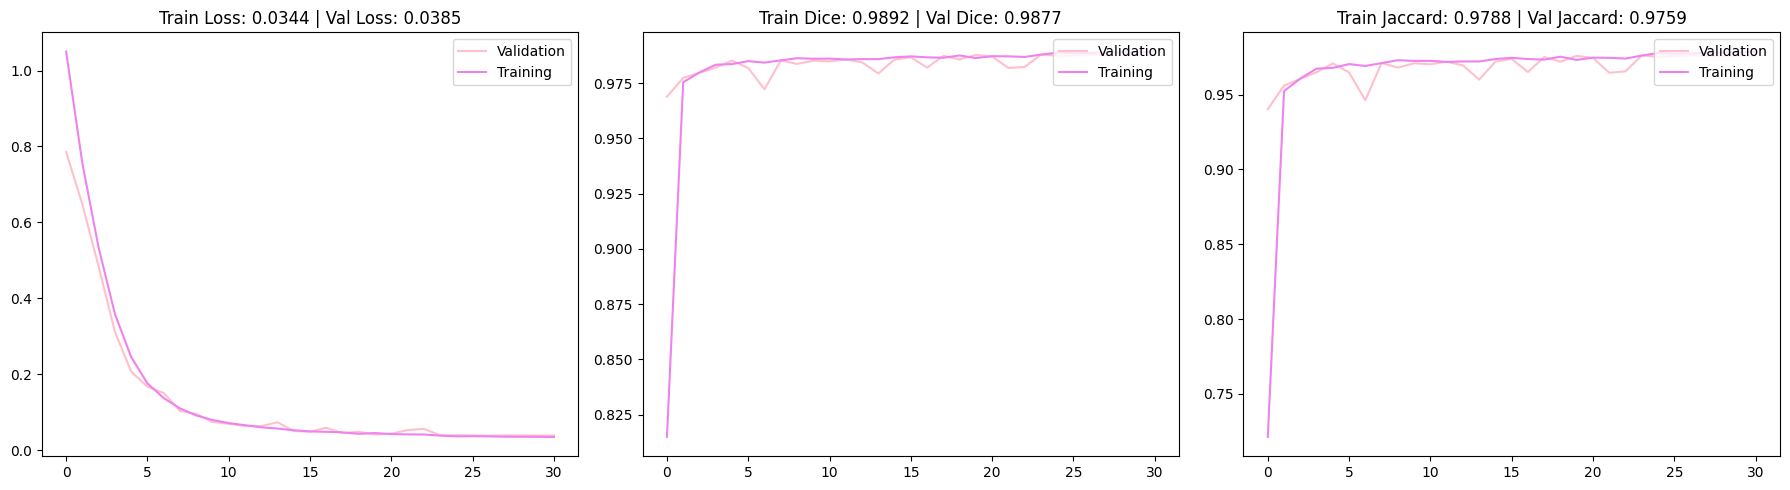

train epoch 32/50: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


Loss: 0.0342 | Dice: 0.9892 | IoU: 0.9788


val epoch 32/50: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Loss: 0.0382 | Dice: 0.9878 | IoU: 0.9760


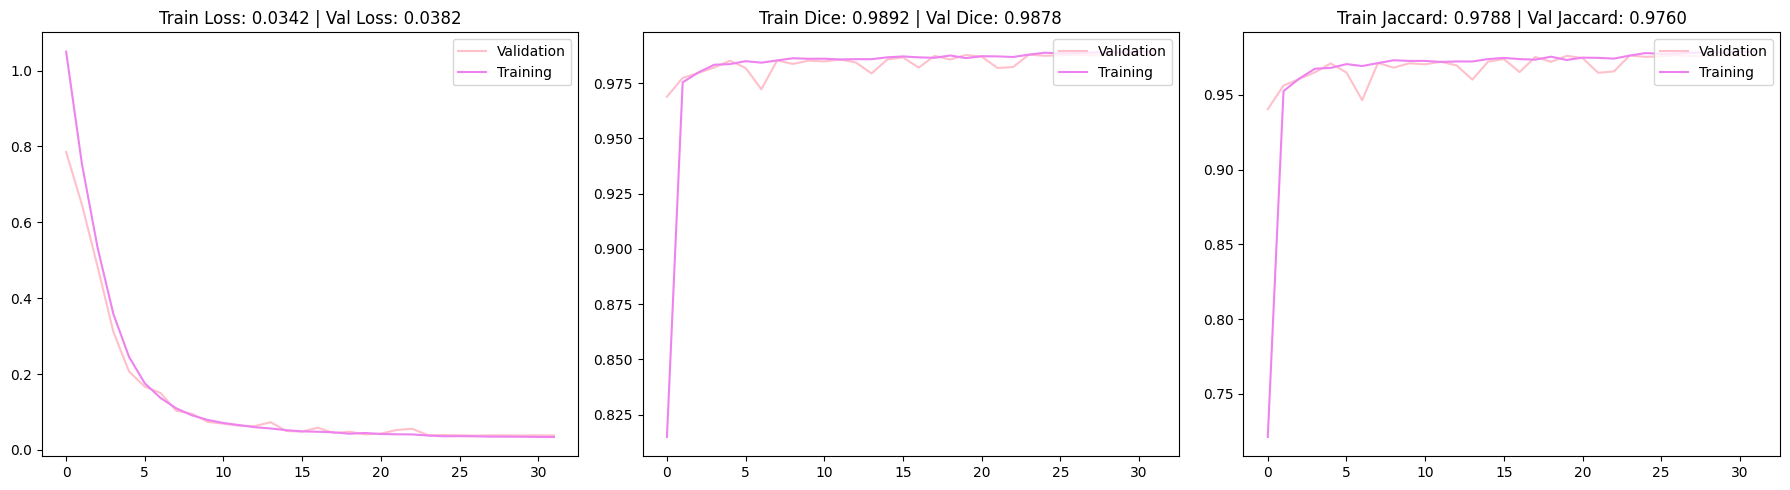

train epoch 33/50: 100%|██████████| 40/40 [00:17<00:00,  2.32it/s]


Loss: 0.0347 | Dice: 0.9891 | IoU: 0.9784


val epoch 33/50: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Loss: 0.0380 | Dice: 0.9878 | IoU: 0.9762
Epoch 00033: reducing learning rate of group 0 to 5.0000e-07.


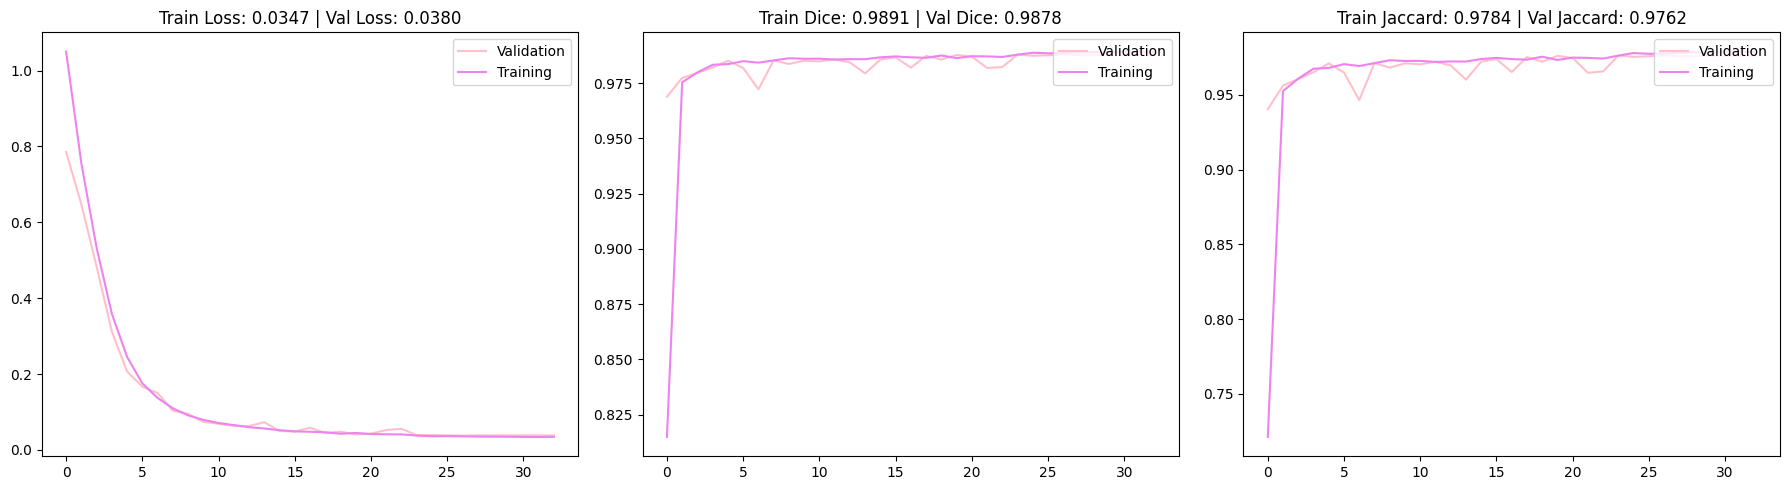

train epoch 34/50: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s]


Loss: 0.0339 | Dice: 0.9894 | IoU: 0.9791


val epoch 34/50: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Loss: 0.0381 | Dice: 0.9878 | IoU: 0.9762


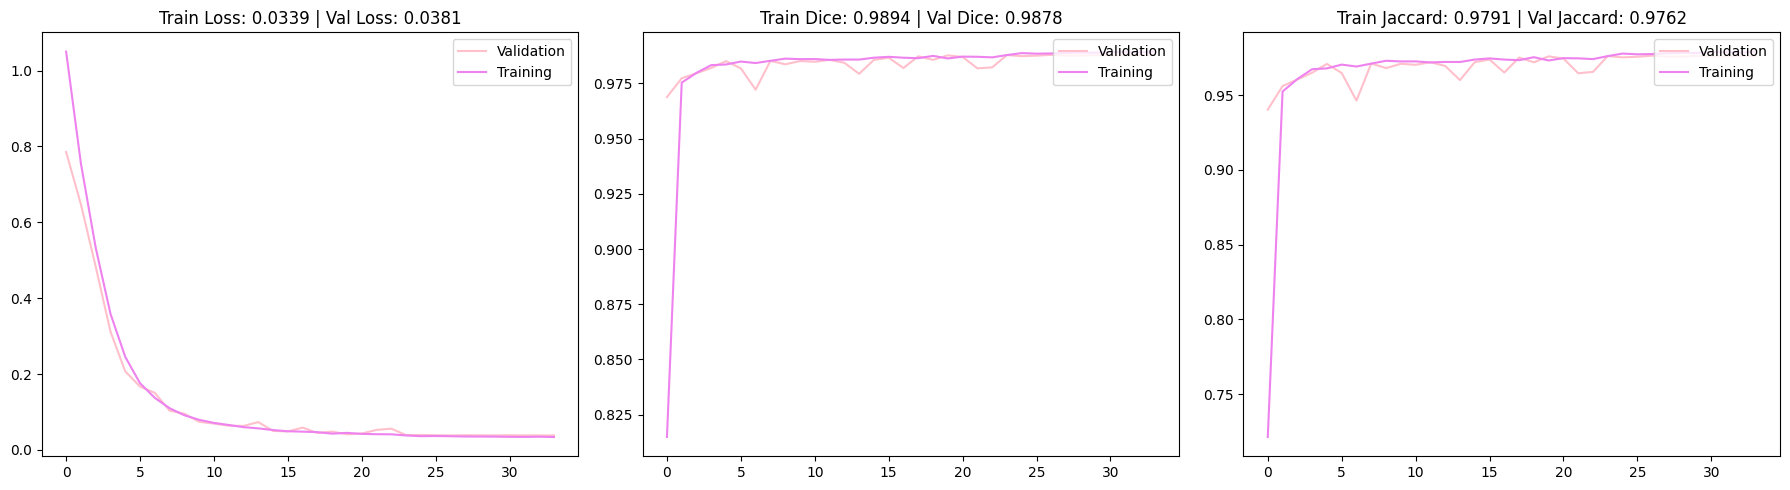

train epoch 35/50: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


Loss: 0.0346 | Dice: 0.9891 | IoU: 0.9786


val epoch 35/50: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


Loss: 0.0386 | Dice: 0.9876 | IoU: 0.9758


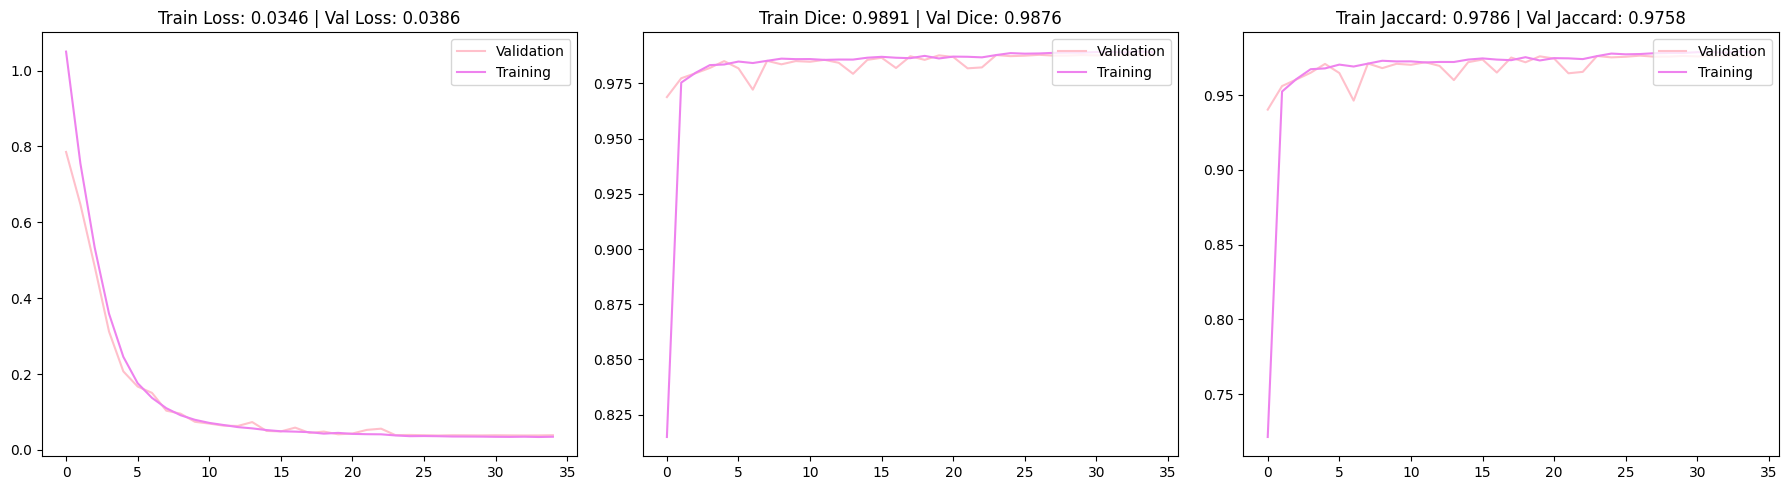

train epoch 36/50: 100%|██████████| 40/40 [00:16<00:00,  2.40it/s]


Loss: 0.0341 | Dice: 0.9893 | IoU: 0.9789


val epoch 36/50: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


Loss: 0.0389 | Dice: 0.9875 | IoU: 0.9756
Epoch 00036: reducing learning rate of group 0 to 5.0000e-08.


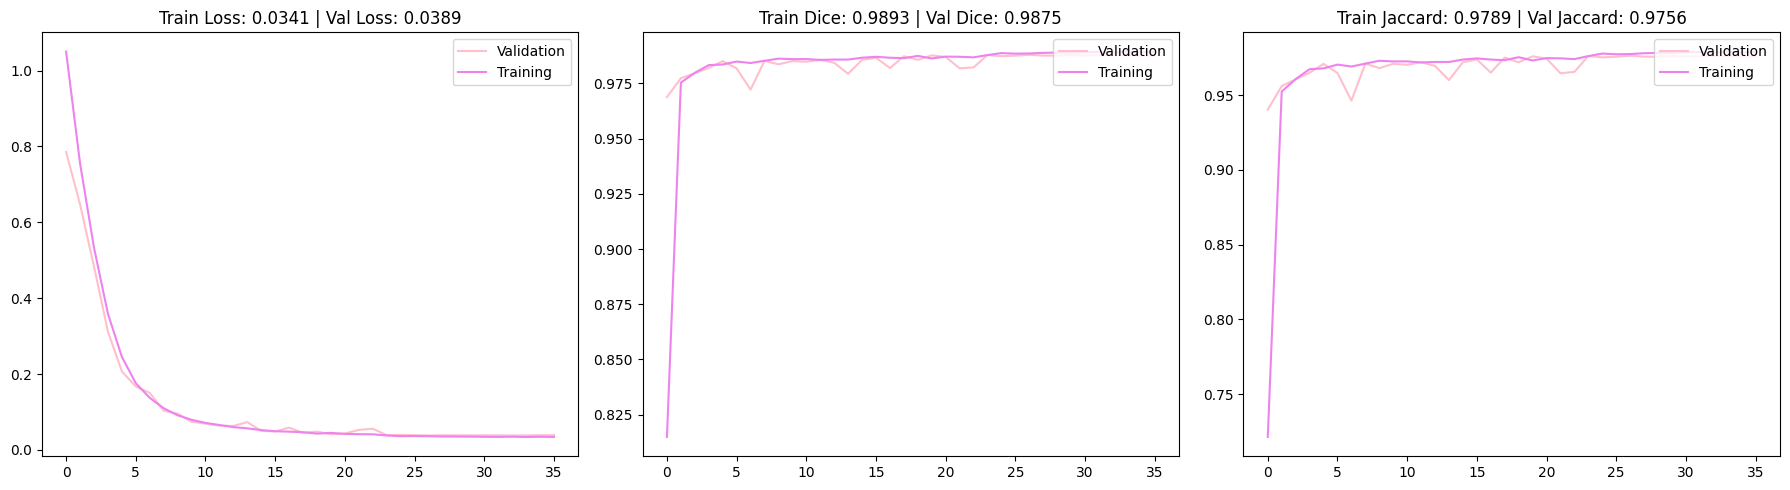

train epoch 37/50: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s]


Loss: 0.0343 | Dice: 0.9892 | IoU: 0.9787


val epoch 37/50: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Loss: 0.0382 | Dice: 0.9877 | IoU: 0.9759


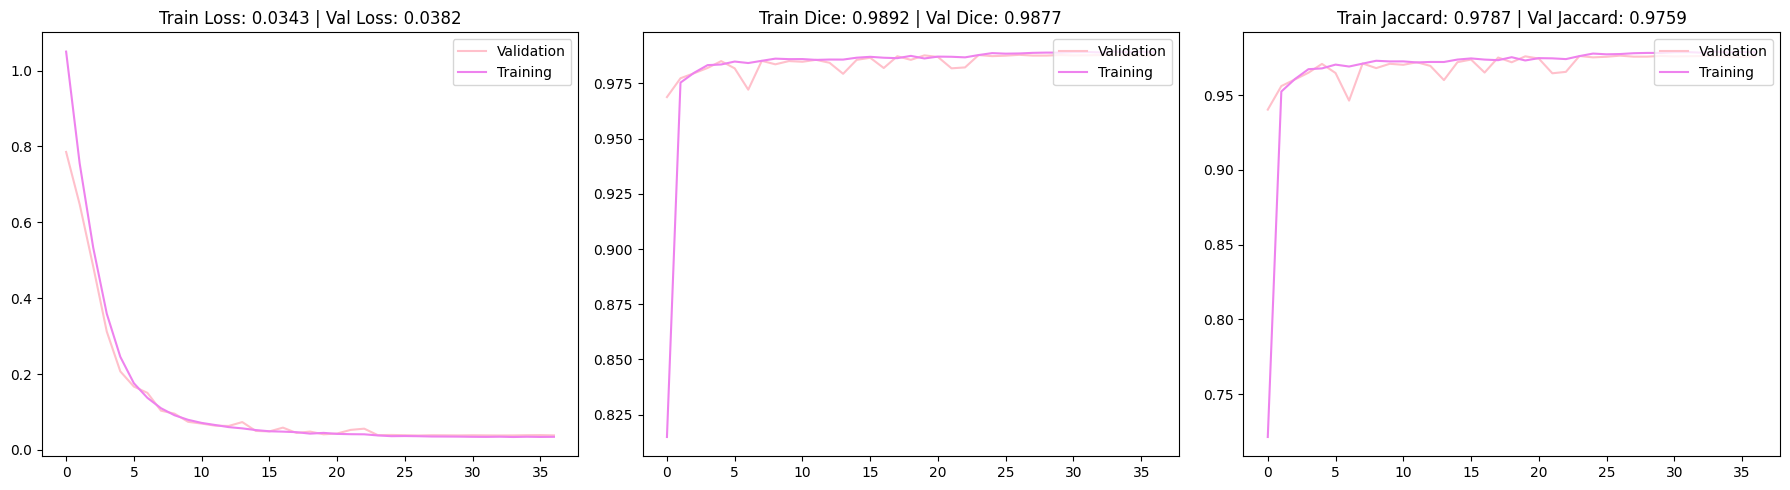

train epoch 38/50: 100%|██████████| 40/40 [00:16<00:00,  2.41it/s]


Loss: 0.0341 | Dice: 0.9893 | IoU: 0.9789


val epoch 38/50: 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


Loss: 0.0385 | Dice: 0.9877 | IoU: 0.9759


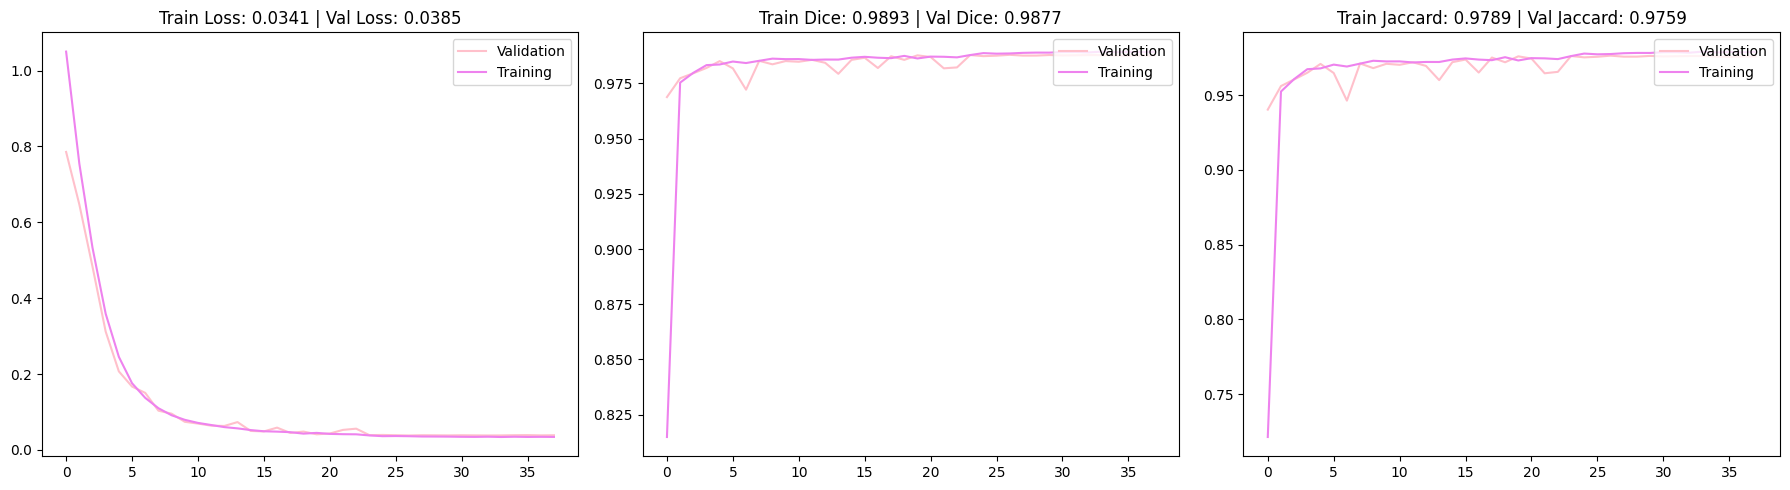

train epoch 39/50: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s]


Loss: 0.0336 | Dice: 0.9895 | IoU: 0.9793


val epoch 39/50: 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]


Loss: 0.0383 | Dice: 0.9877 | IoU: 0.9759
Epoch 00039: reducing learning rate of group 0 to 5.0000e-09.


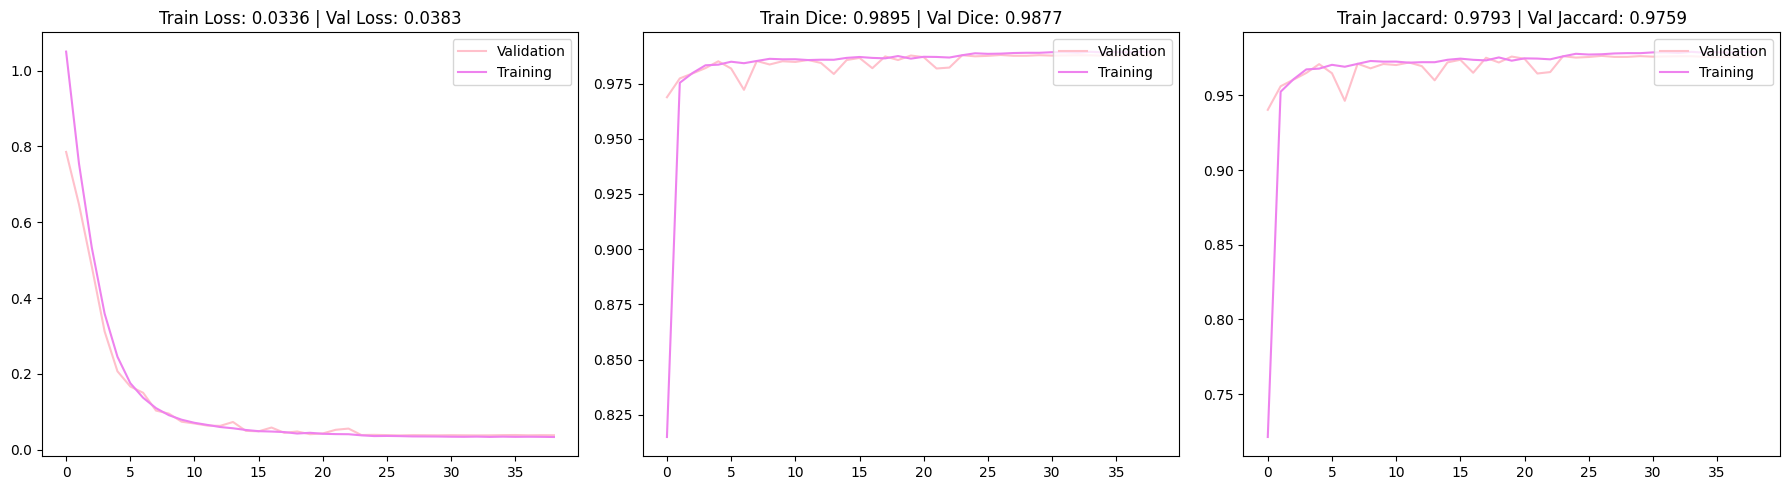

train epoch 40/50: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s]


Loss: 0.0345 | Dice: 0.9892 | IoU: 0.9787


val epoch 40/50: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Loss: 0.0388 | Dice: 0.9875 | IoU: 0.9756


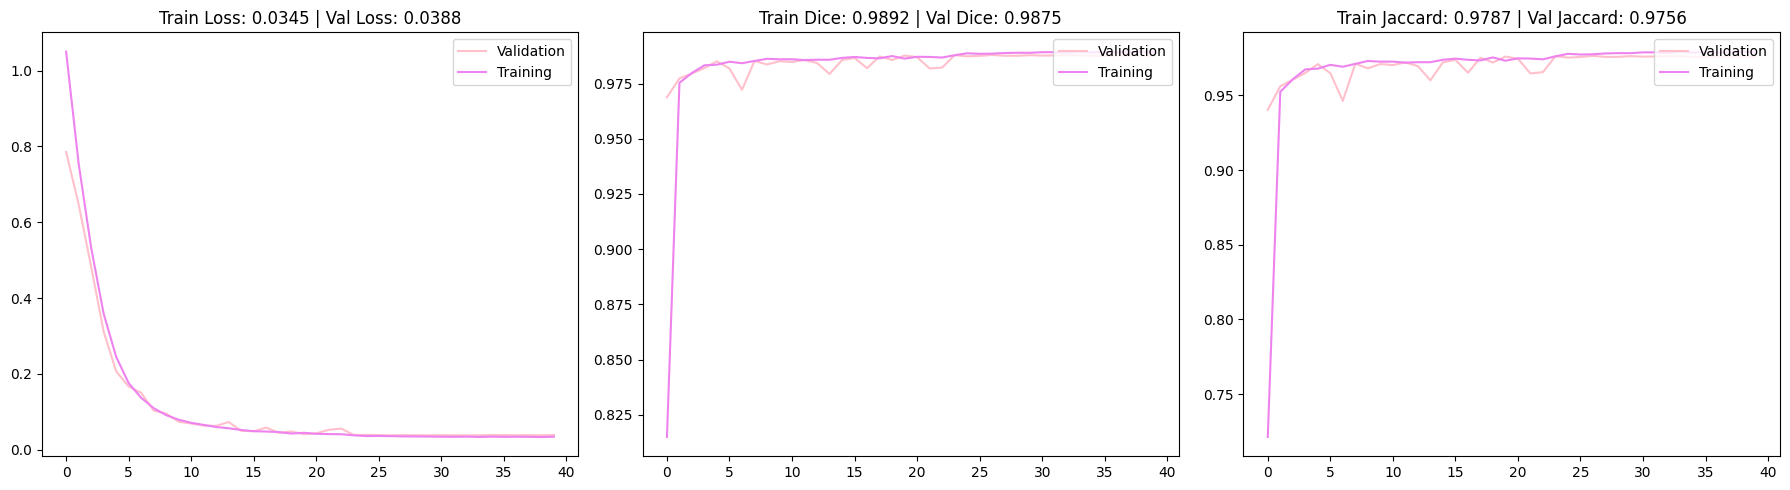

train epoch 41/50: 100%|██████████| 40/40 [00:16<00:00,  2.38it/s]


Loss: 0.0339 | Dice: 0.9896 | IoU: 0.9794


val epoch 41/50: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Loss: 0.0383 | Dice: 0.9877 | IoU: 0.9760


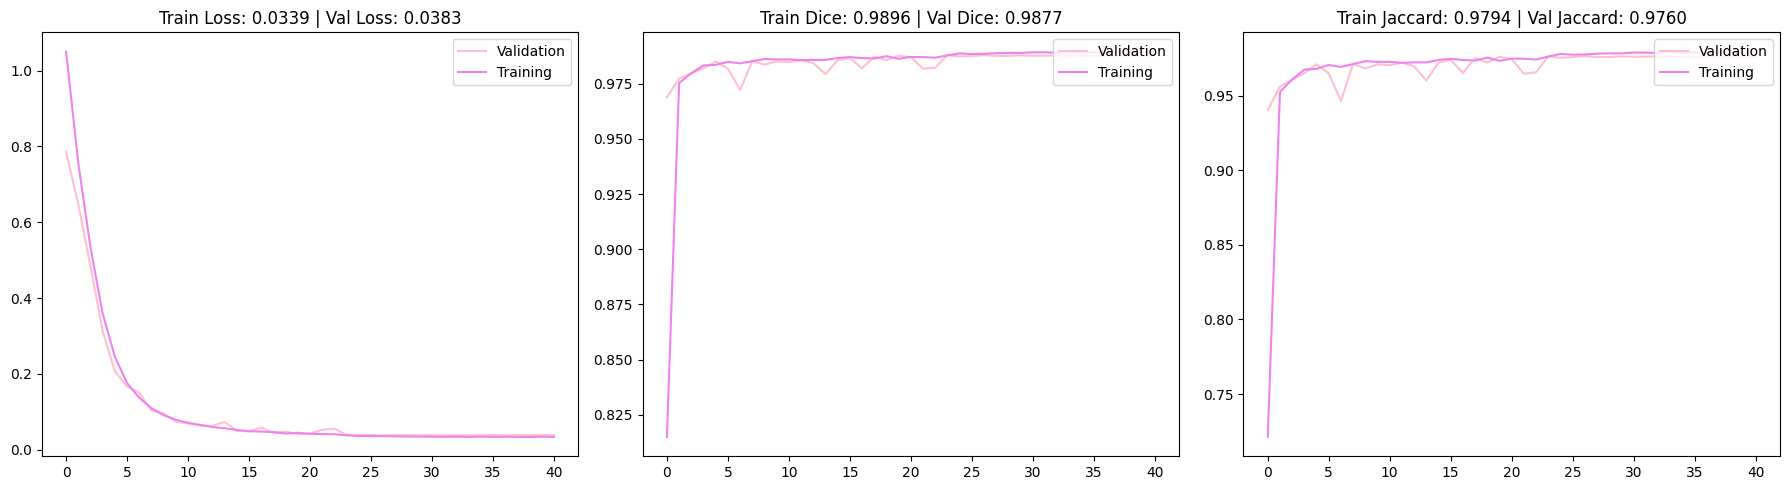

train epoch 42/50: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


Loss: 0.0346 | Dice: 0.9891 | IoU: 0.9785


val epoch 42/50: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


Loss: 0.0385 | Dice: 0.9876 | IoU: 0.9758


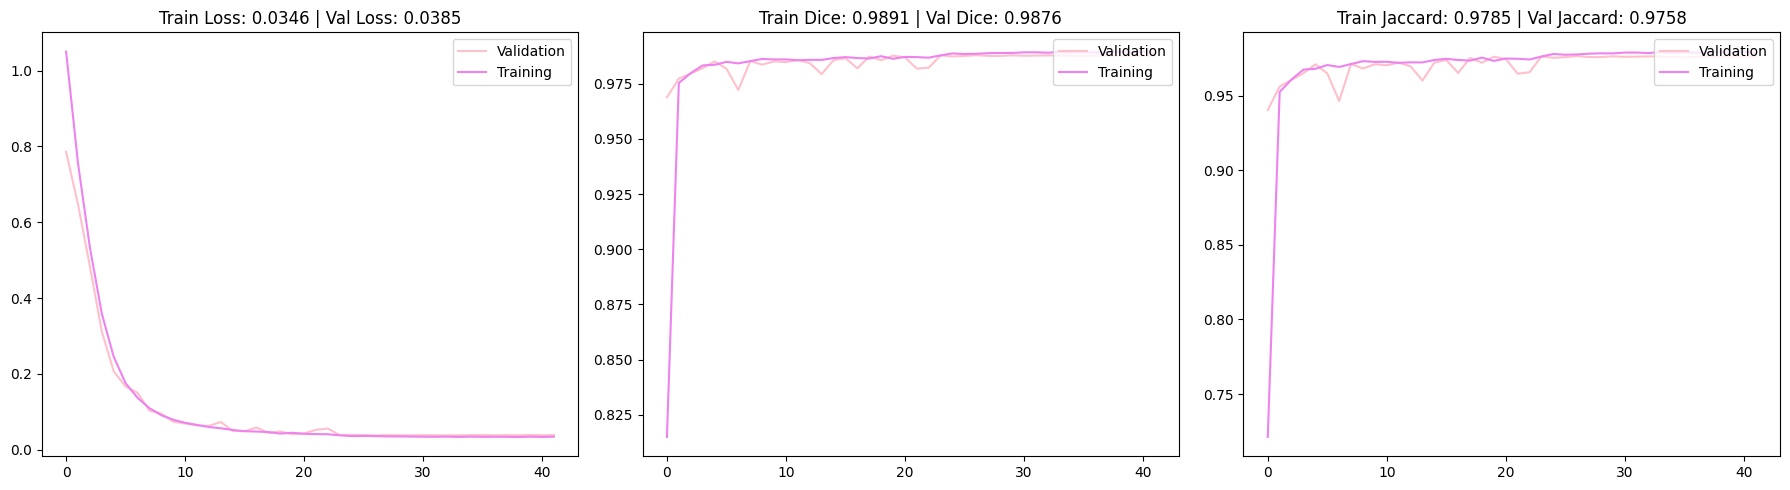

train epoch 43/50: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s]


Loss: 0.0341 | Dice: 0.9892 | IoU: 0.9788


val epoch 43/50: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Loss: 0.0381 | Dice: 0.9878 | IoU: 0.9761


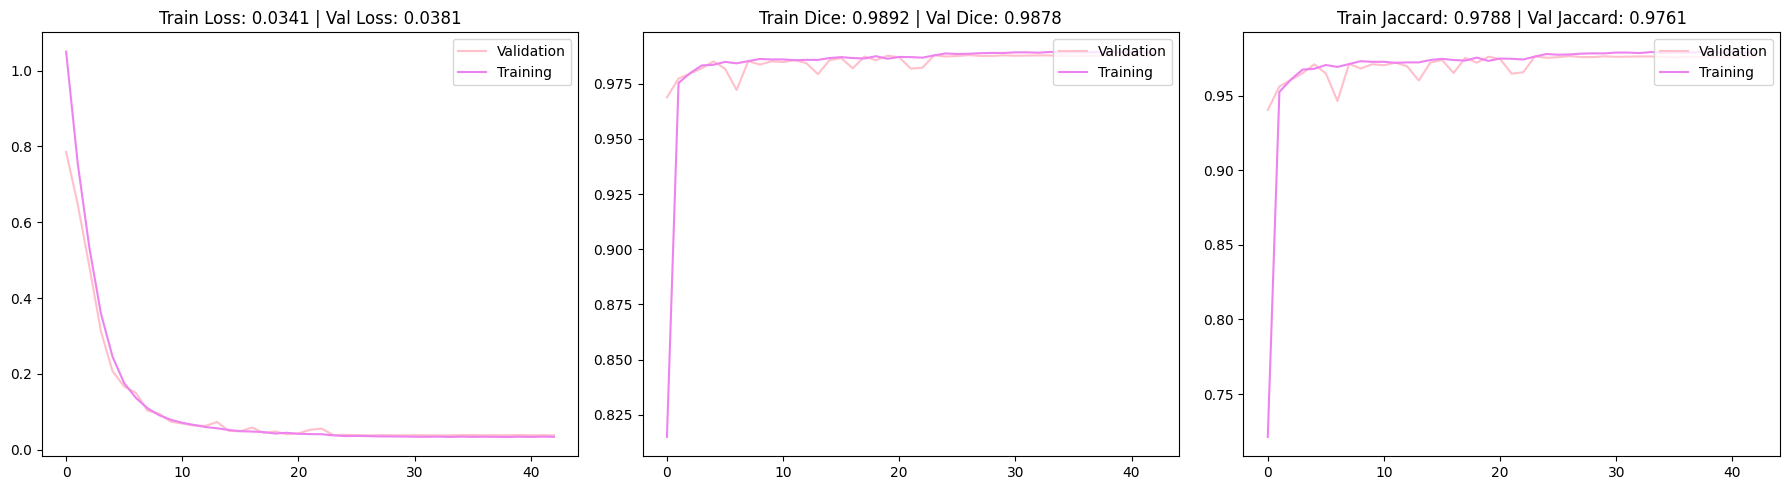

train epoch 44/50: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


Loss: 0.0343 | Dice: 0.9892 | IoU: 0.9787


val epoch 44/50: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Loss: 0.0388 | Dice: 0.9876 | IoU: 0.9757


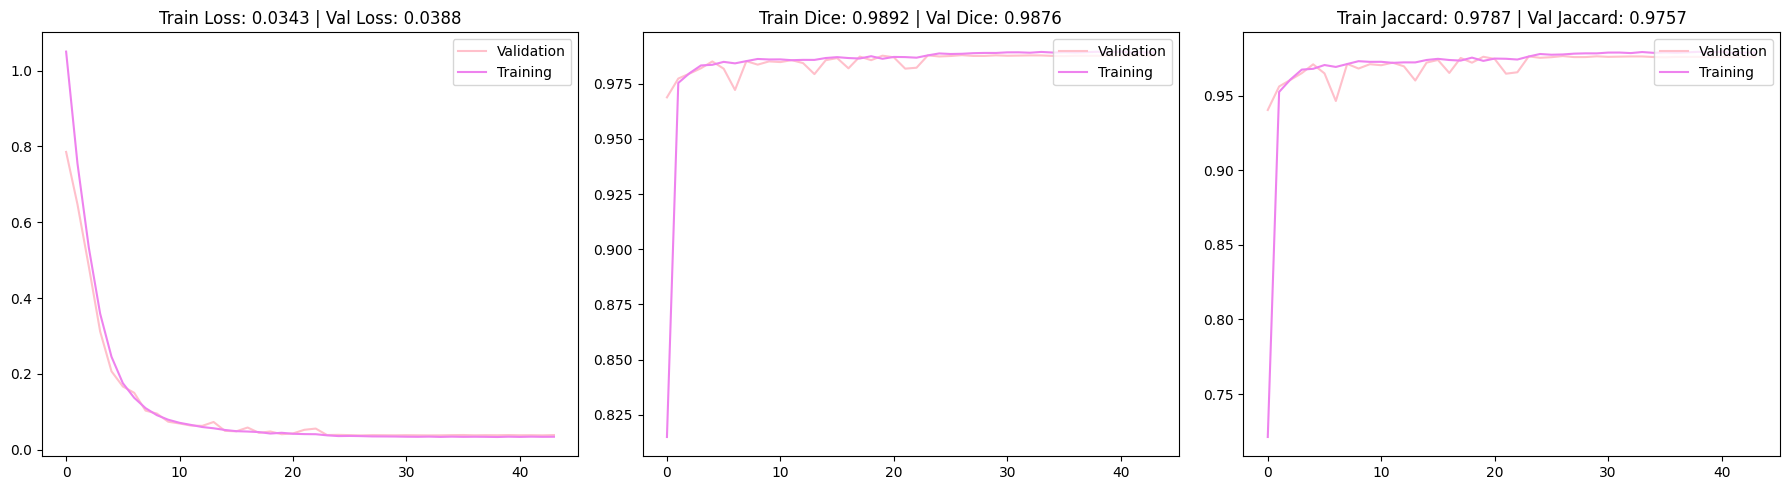

train epoch 45/50: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s]


Loss: 0.0342 | Dice: 0.9893 | IoU: 0.9789


val epoch 45/50: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Loss: 0.0384 | Dice: 0.9877 | IoU: 0.9759


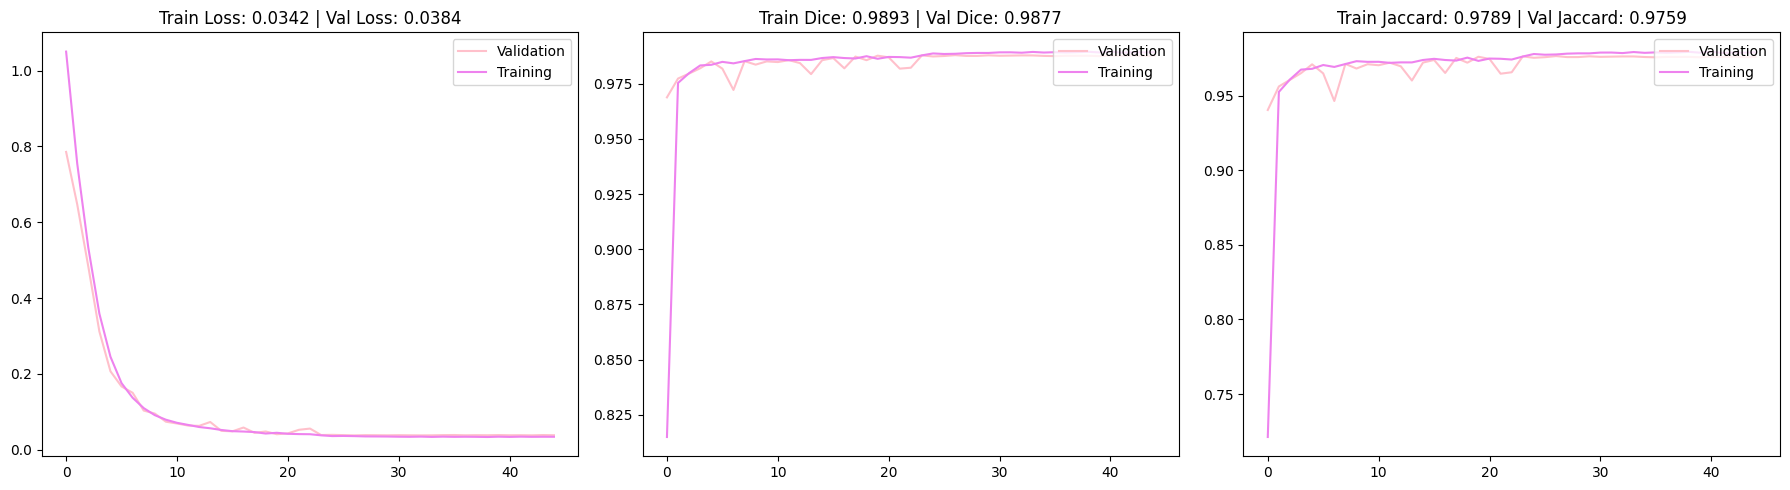

train epoch 46/50: 100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


Loss: 0.0345 | Dice: 0.9892 | IoU: 0.9787


val epoch 46/50: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Loss: 0.0381 | Dice: 0.9877 | IoU: 0.9760


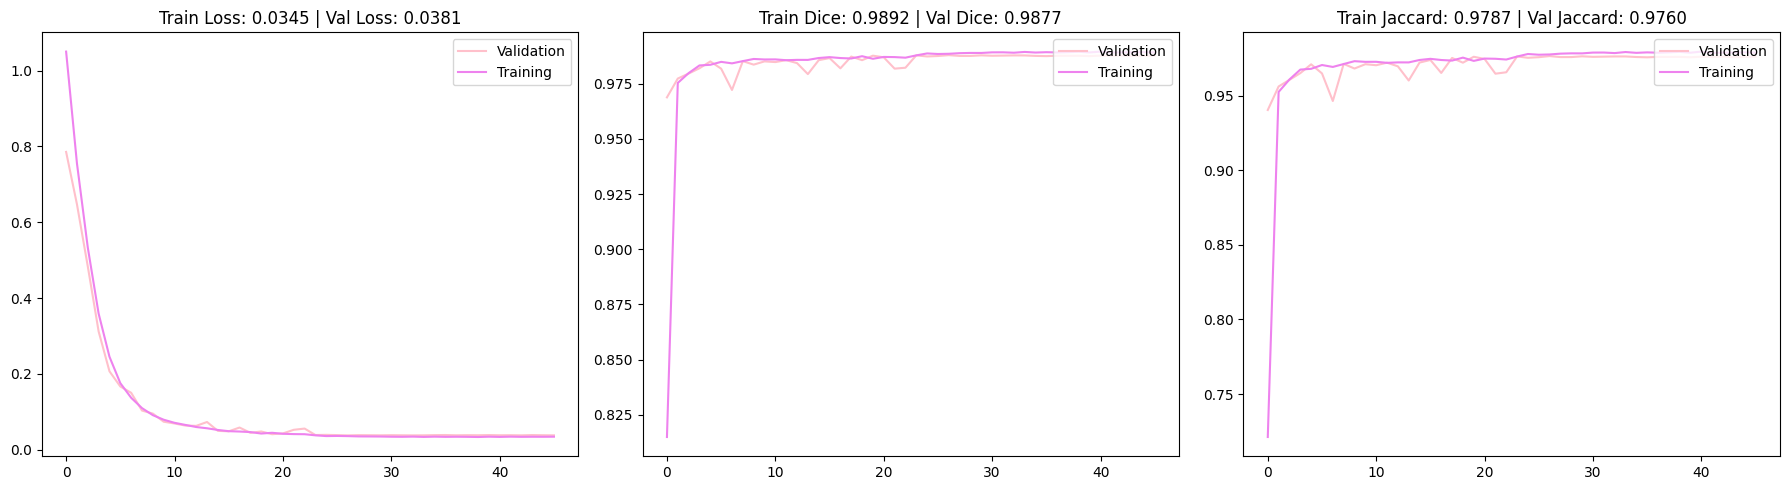

train epoch 47/50: 100%|██████████| 40/40 [00:16<00:00,  2.42it/s]


Loss: 0.0339 | Dice: 0.9894 | IoU: 0.9790


val epoch 47/50: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


Loss: 0.0386 | Dice: 0.9877 | IoU: 0.9759


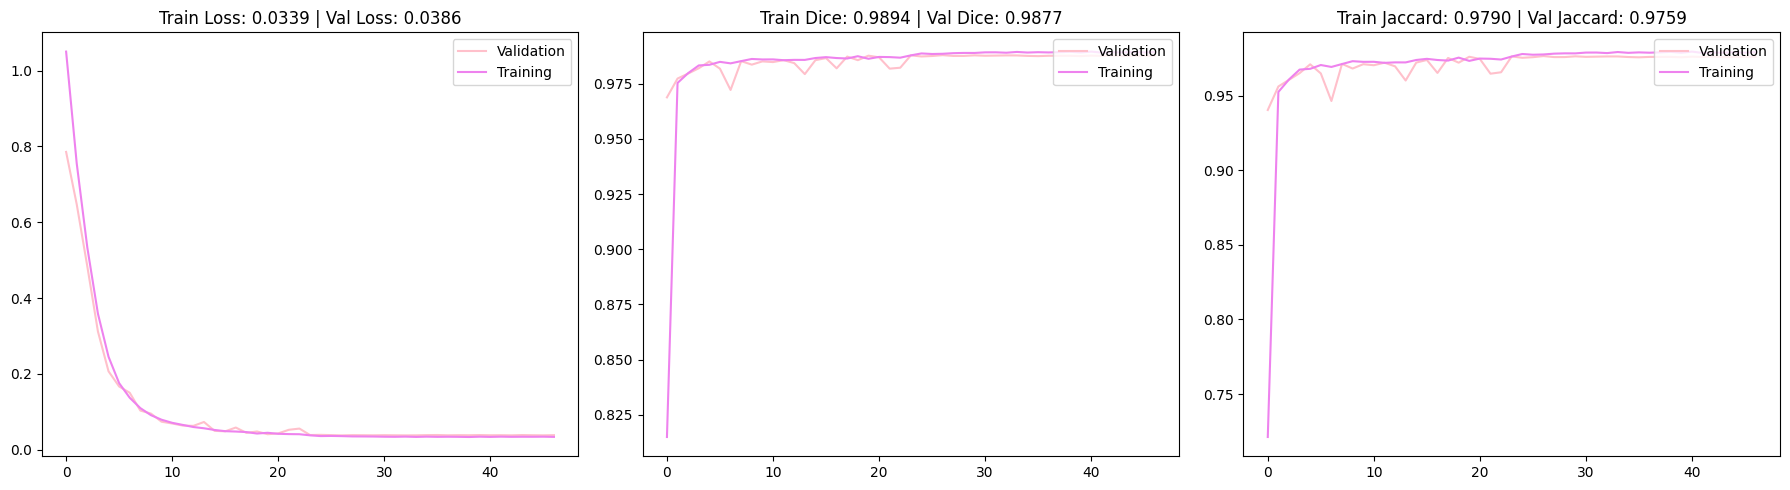

train epoch 48/50: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s]


Loss: 0.0340 | Dice: 0.9894 | IoU: 0.9790


val epoch 48/50: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Loss: 0.0384 | Dice: 0.9877 | IoU: 0.9759


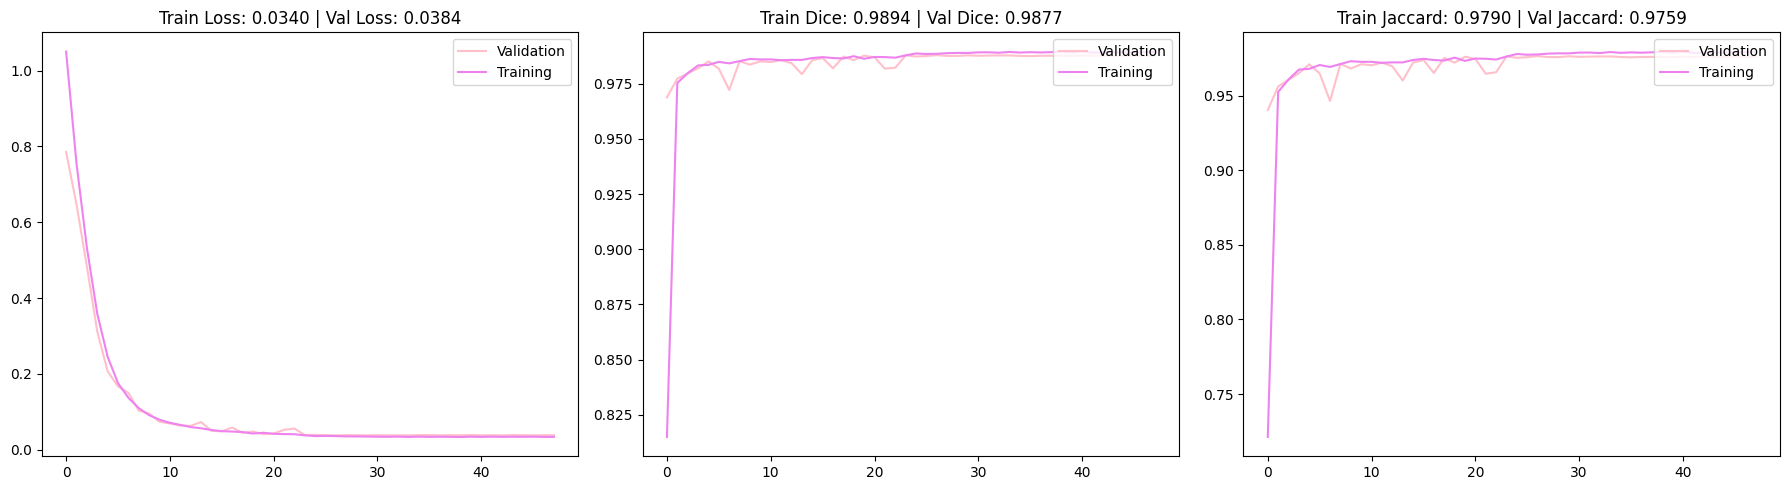

train epoch 49/50: 100%|██████████| 40/40 [00:16<00:00,  2.39it/s]


Loss: 0.0341 | Dice: 0.9893 | IoU: 0.9789


val epoch 49/50: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


Loss: 0.0390 | Dice: 0.9875 | IoU: 0.9755


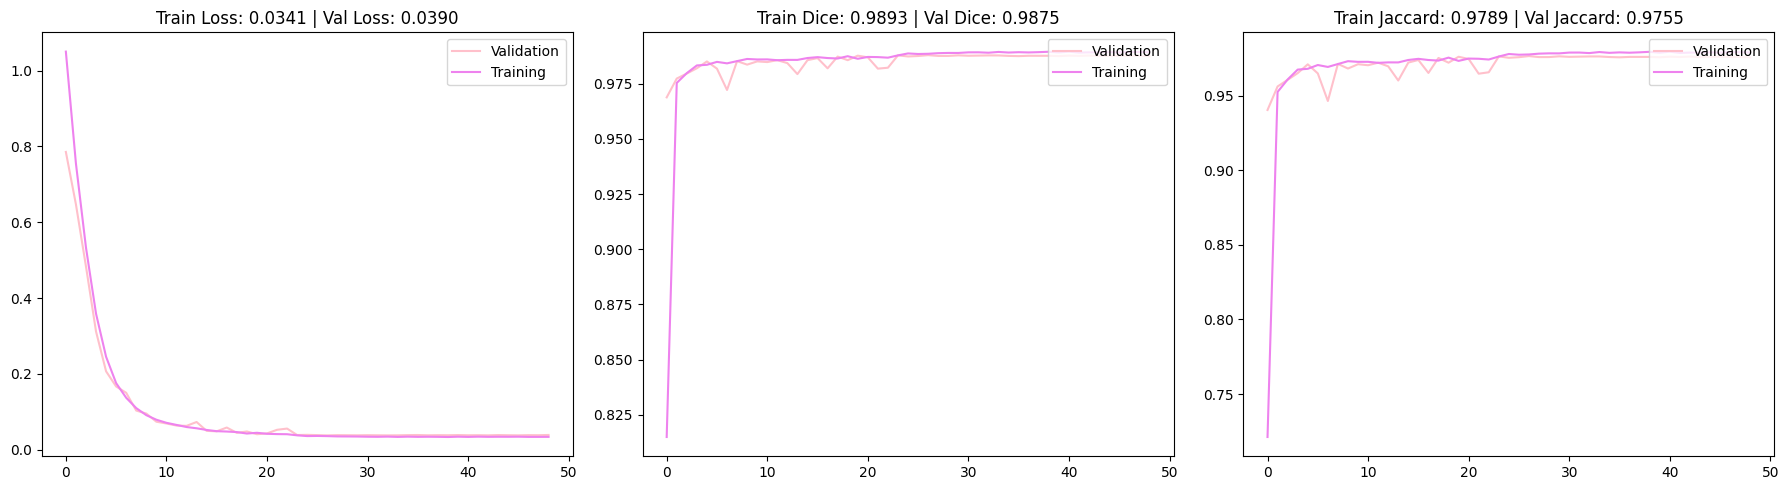

train epoch 50/50: 100%|██████████| 40/40 [00:16<00:00,  2.45it/s]


Loss: 0.0340 | Dice: 0.9894 | IoU: 0.9792


val epoch 50/50: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Loss: 0.0389 | Dice: 0.9875 | IoU: 0.9756


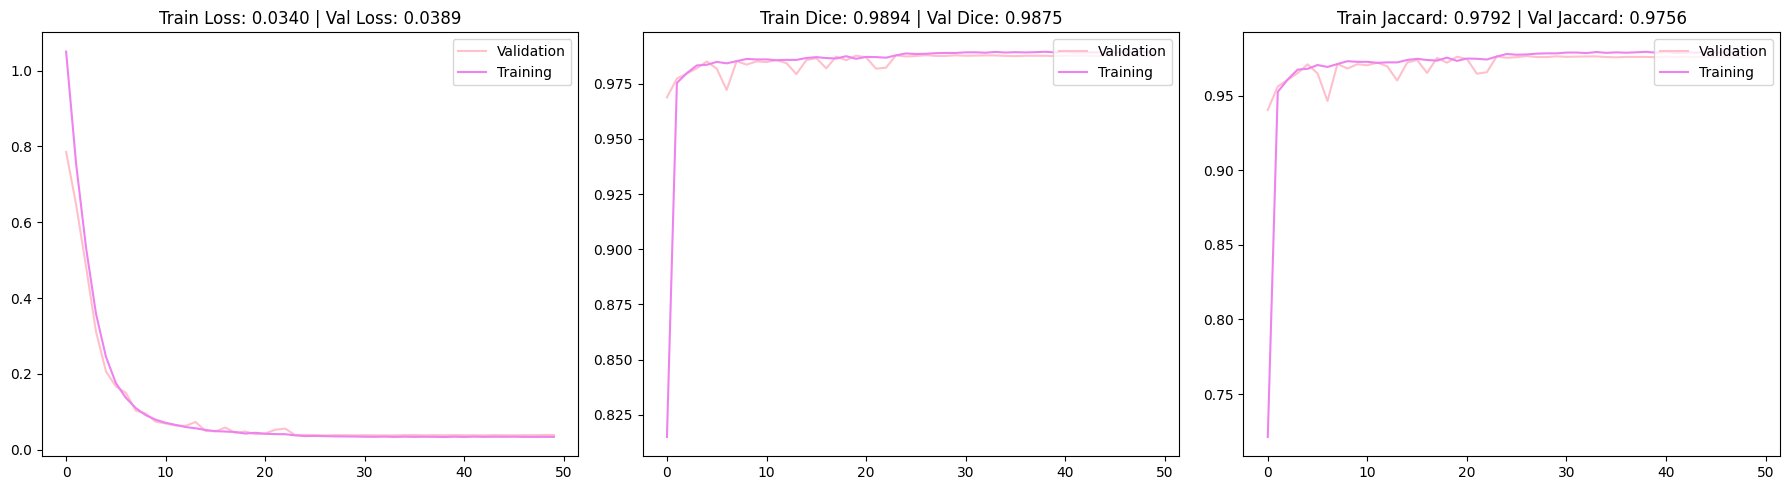


CPU times: user 12min 8s, sys: 54.1 s, total: 13min 2s
Wall time: 21min 26s


In [22]:
%%time
trainer.run()

In [23]:
## Evaluacija modela po klasama, računajući Dice i Jaccard koeficijente za svaku klasu
def compute_scores_per_classes(model, dataloader, classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            #imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs.float())
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()


            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [24]:
model.eval();

In [25]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(model, valid_dl, ['WT', 'TC', 'ET', 'BG'])

CPU times: user 999 ms, sys: 206 ms, total: 1.21 s
Wall time: 1.98 s


In [26]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice', 'BG dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard', 'BG jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard',
                                      'BG dice', 'BG jaccard']]
val_metics_df.sample(5)

WT dice    WT jaccard   TC dice  TC jaccard  ET dice  ET jaccard  \
22  1.000000e+00  1.000000e+00  0.917991    0.848413      1.0         1.0   
29  1.052632e-11  1.052632e-11  0.391727    0.243570      1.0         1.0   
19  1.000000e+00  1.000000e+00  0.751201    0.601539      1.0         1.0   
0   1.001001e-12  1.001001e-12  0.505773    0.338485      1.0         1.0   
40  1.000000e+00  1.000000e+00  0.745579    0.594361      1.0         1.0   

     BG dice  BG jaccard  
22  0.994959    0.989969  
29  0.986833    0.974008  
19  0.992008    0.984143  
0   0.975641    0.952440  
40  0.984676    0.969815

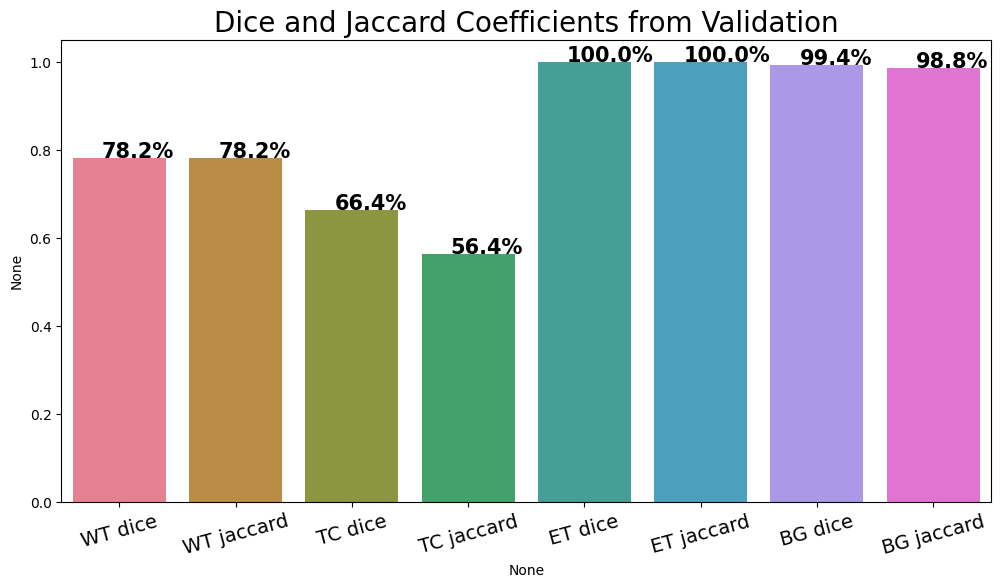

In [27]:
## Prosječne vrijednosti Dice i Jaccard koeficijenata za svaku od klasa na validacijskom skupu

unique_categories = val_metics_df.mean().index
palette = sns.color_palette("husl", len(unique_categories))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), hue=val_metics_df.mean().index, palette=palette, ax=ax, legend=False)

ax.set_xticks(range(len(val_metics_df.mean().index)))
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)

ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')

plt.show()

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_results(data_loader, model, modality_types, device):
    # Fetch and display information from the first few batches
    dl_it = iter(data_loader)
    for _ in range(4):
        imgs, msks = next(dl_it)
        print(imgs.shape)
        print(msks.shape)

        # Ensure the input data has the correct shape
        if len(imgs.shape) == 4:
            # If the data has a single channel (grayscale), remove the channel dimension
            imgs = imgs.squeeze(1)

        # Convert input data to the same type as the model
        imgs = imgs.to(device).float()
        msks = msks.to(device).float()

        # Forward pass to get predictions
        with torch.no_grad():
            predictions = model(imgs)

        # Plot slices for each modality
        num_modalities = len(modality_types)

        plt.figure(figsize=(25, 25))
        for i in range(imgs.shape[0]):
            patient_id = os.path.basename(data_loader.dataset.img_dirs[i])

            # Visualize the MRI modalities
            for j in range(num_modalities):
                plt.subplot(imgs.shape[0], num_modalities + 2, (num_modalities + 2) * i + j + 1)
                plt.imshow(imgs[i, j].cpu().numpy(), cmap='bone')
                plt.axis('off')
                plt.title(f"{modality_types[j]} - {patient_id}")

            # Visualize the ground truth mask
            plt.subplot(imgs.shape[0], num_modalities + 2, (num_modalities + 2) * i + num_modalities + 1)
            plt.imshow(np.argmax(msks[i].cpu().numpy(), axis=0) * 80, cmap='gray_r')
            plt.axis('off')
            plt.title(f"GT MASK - {patient_id}")

            # Visualize the predicted mask
            plt.subplot(imgs.shape[0], num_modalities + 2, (num_modalities + 2) * i + num_modalities + 2)
            plt.imshow(predictions[i, 0].cpu().numpy() * 80, cmap='gray')
            plt.axis('off')
            plt.title(f"Predicted MASK - {patient_id}")

        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        plt.show()

torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])


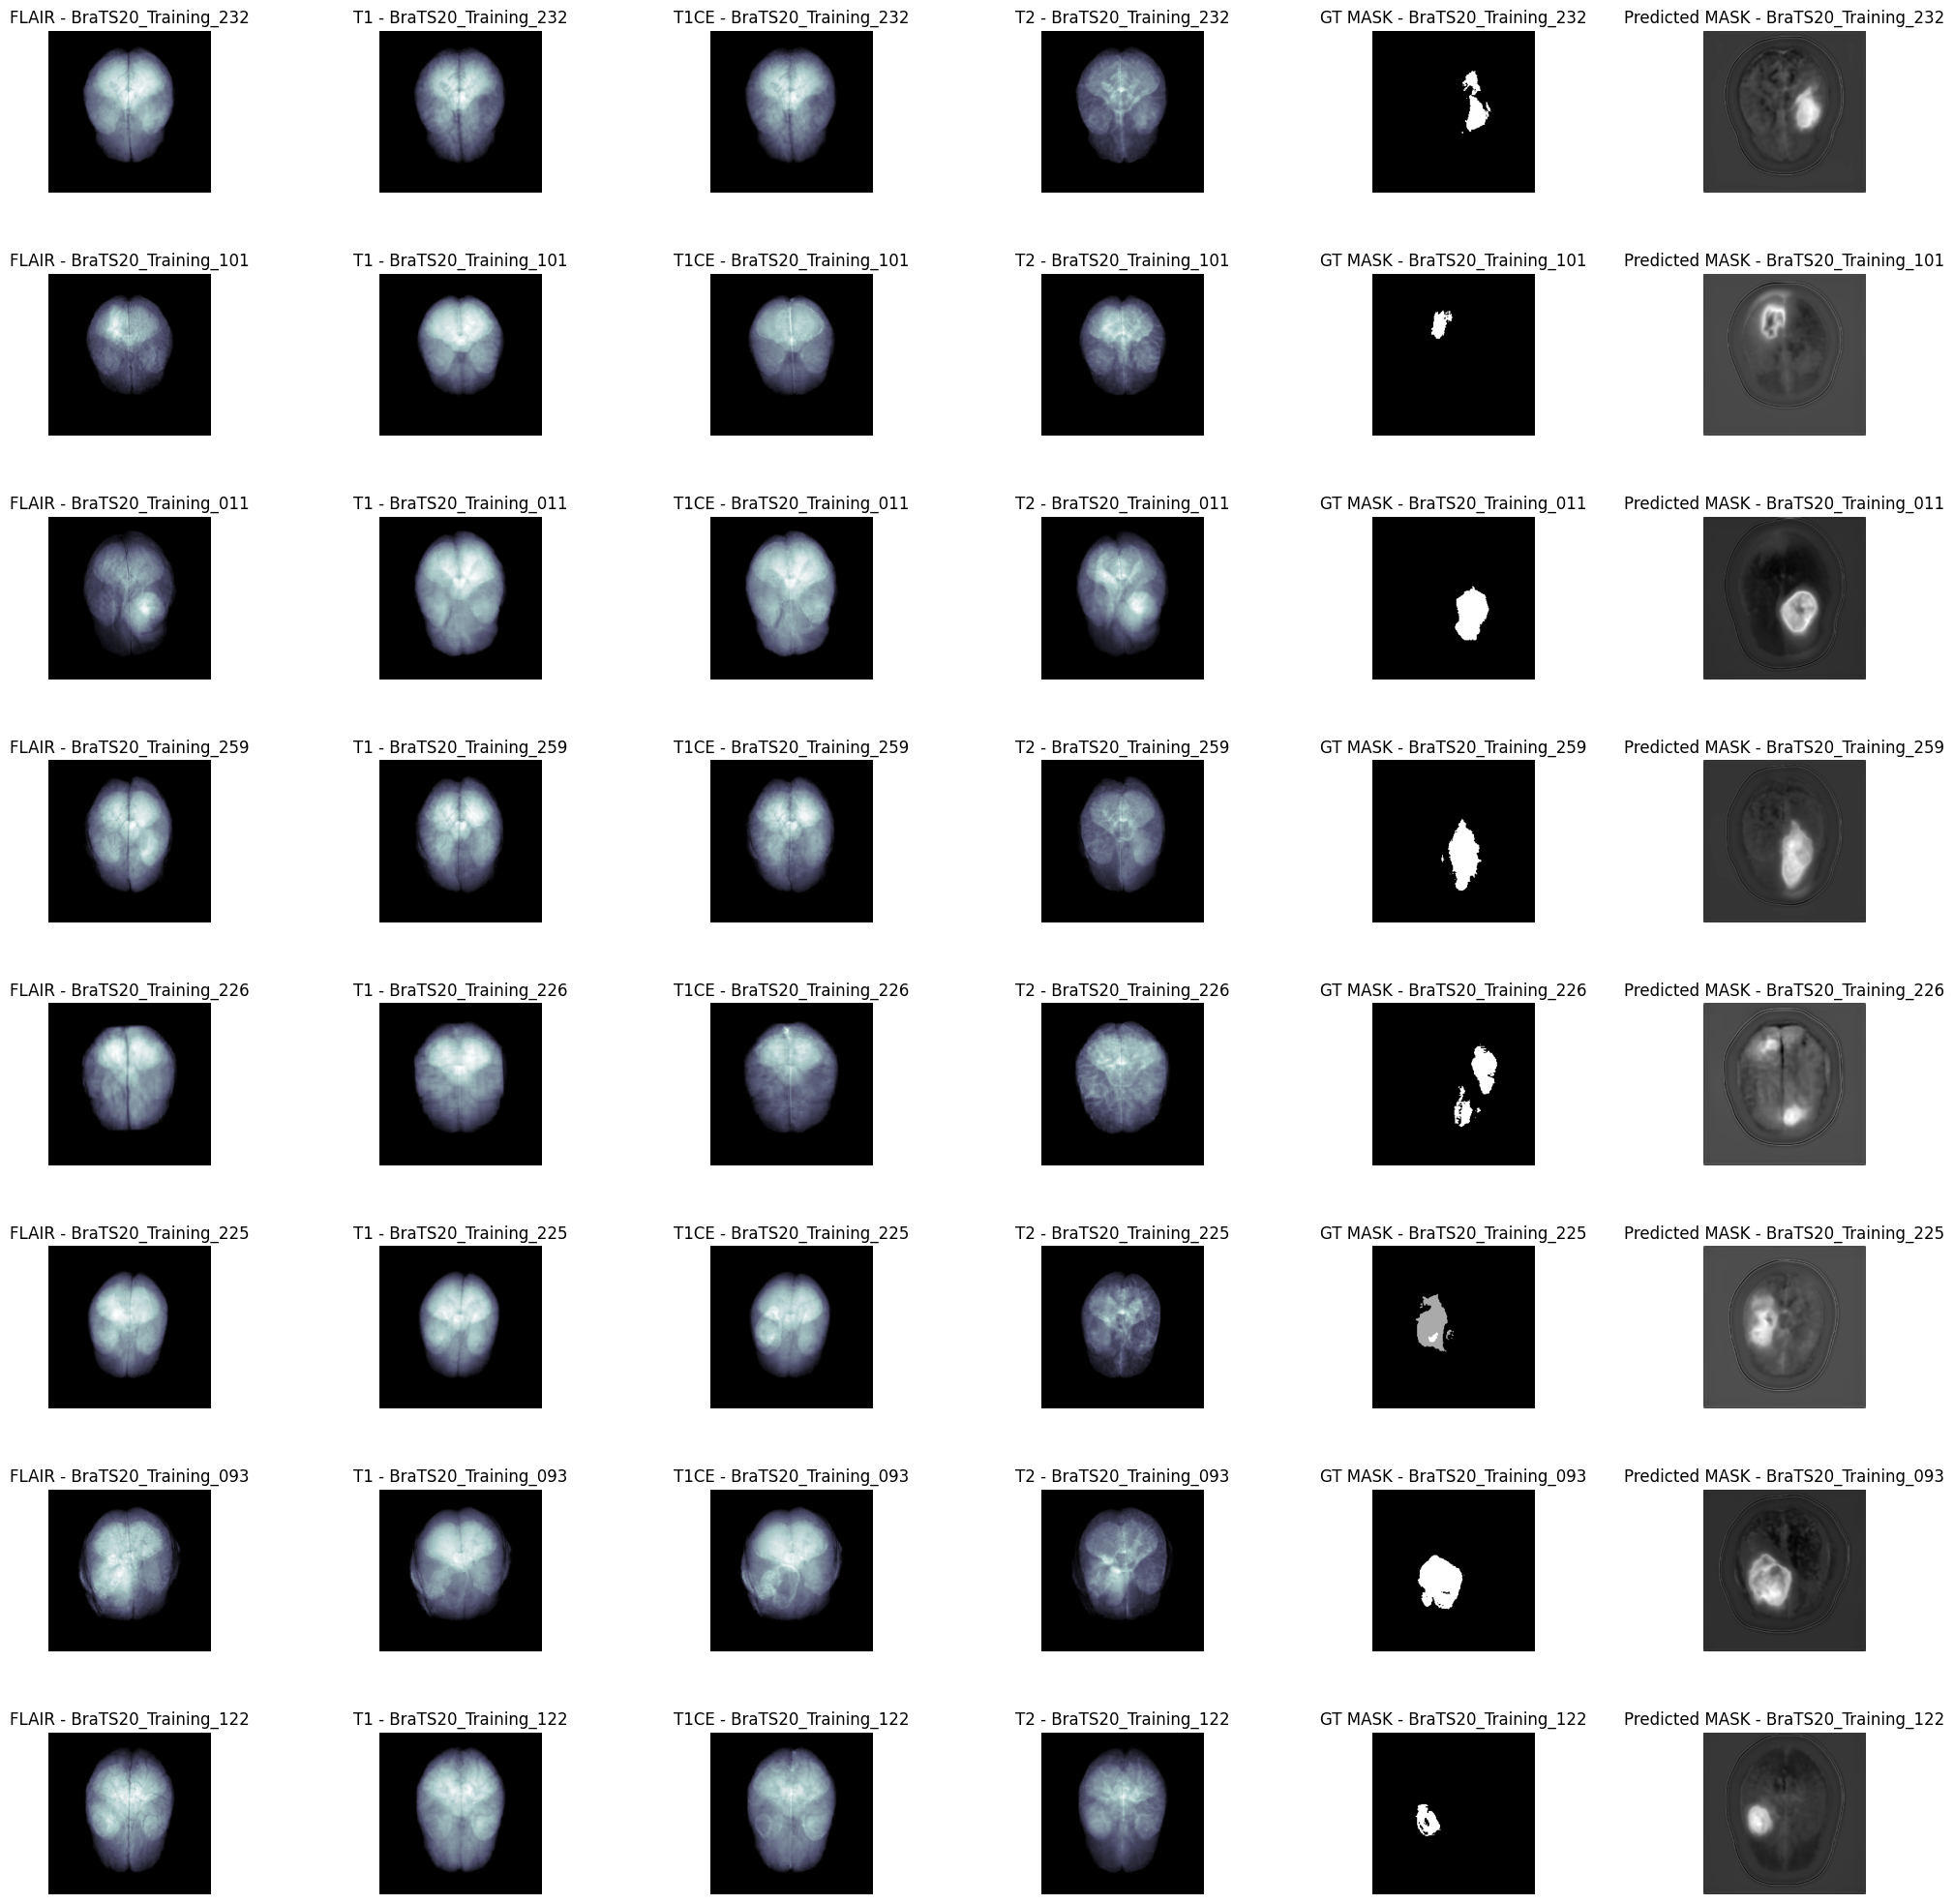

torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])


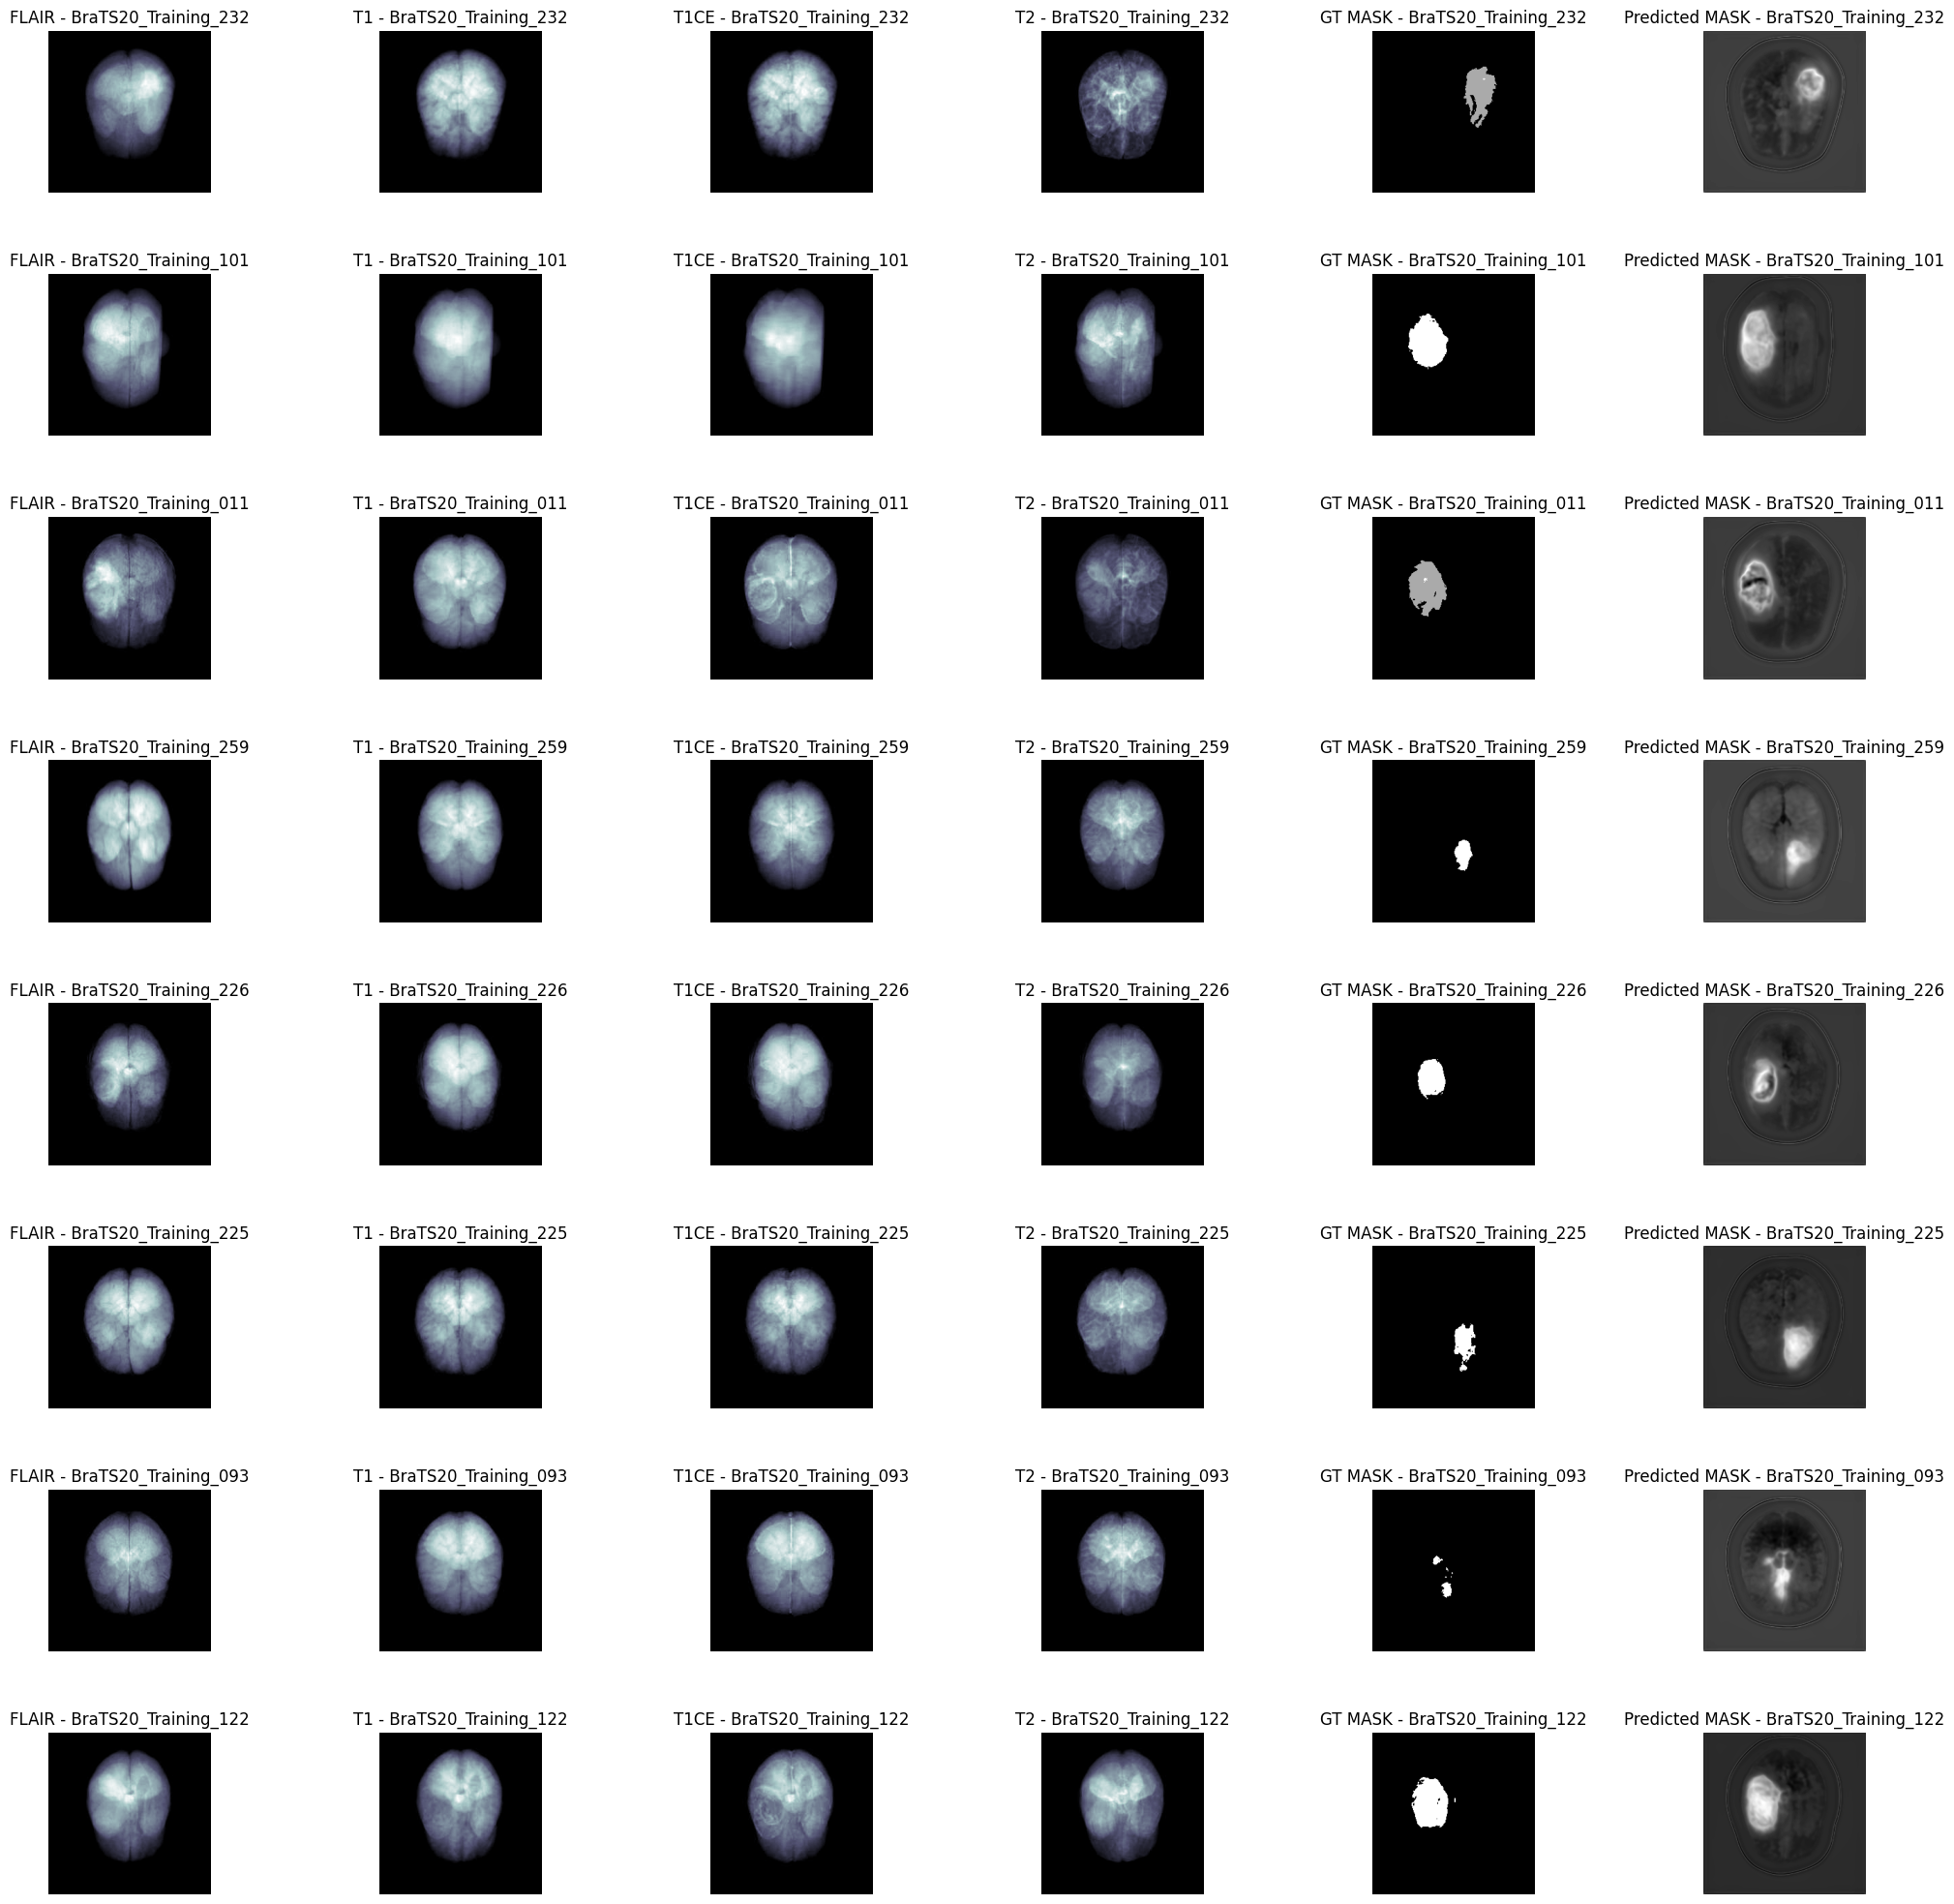

torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])


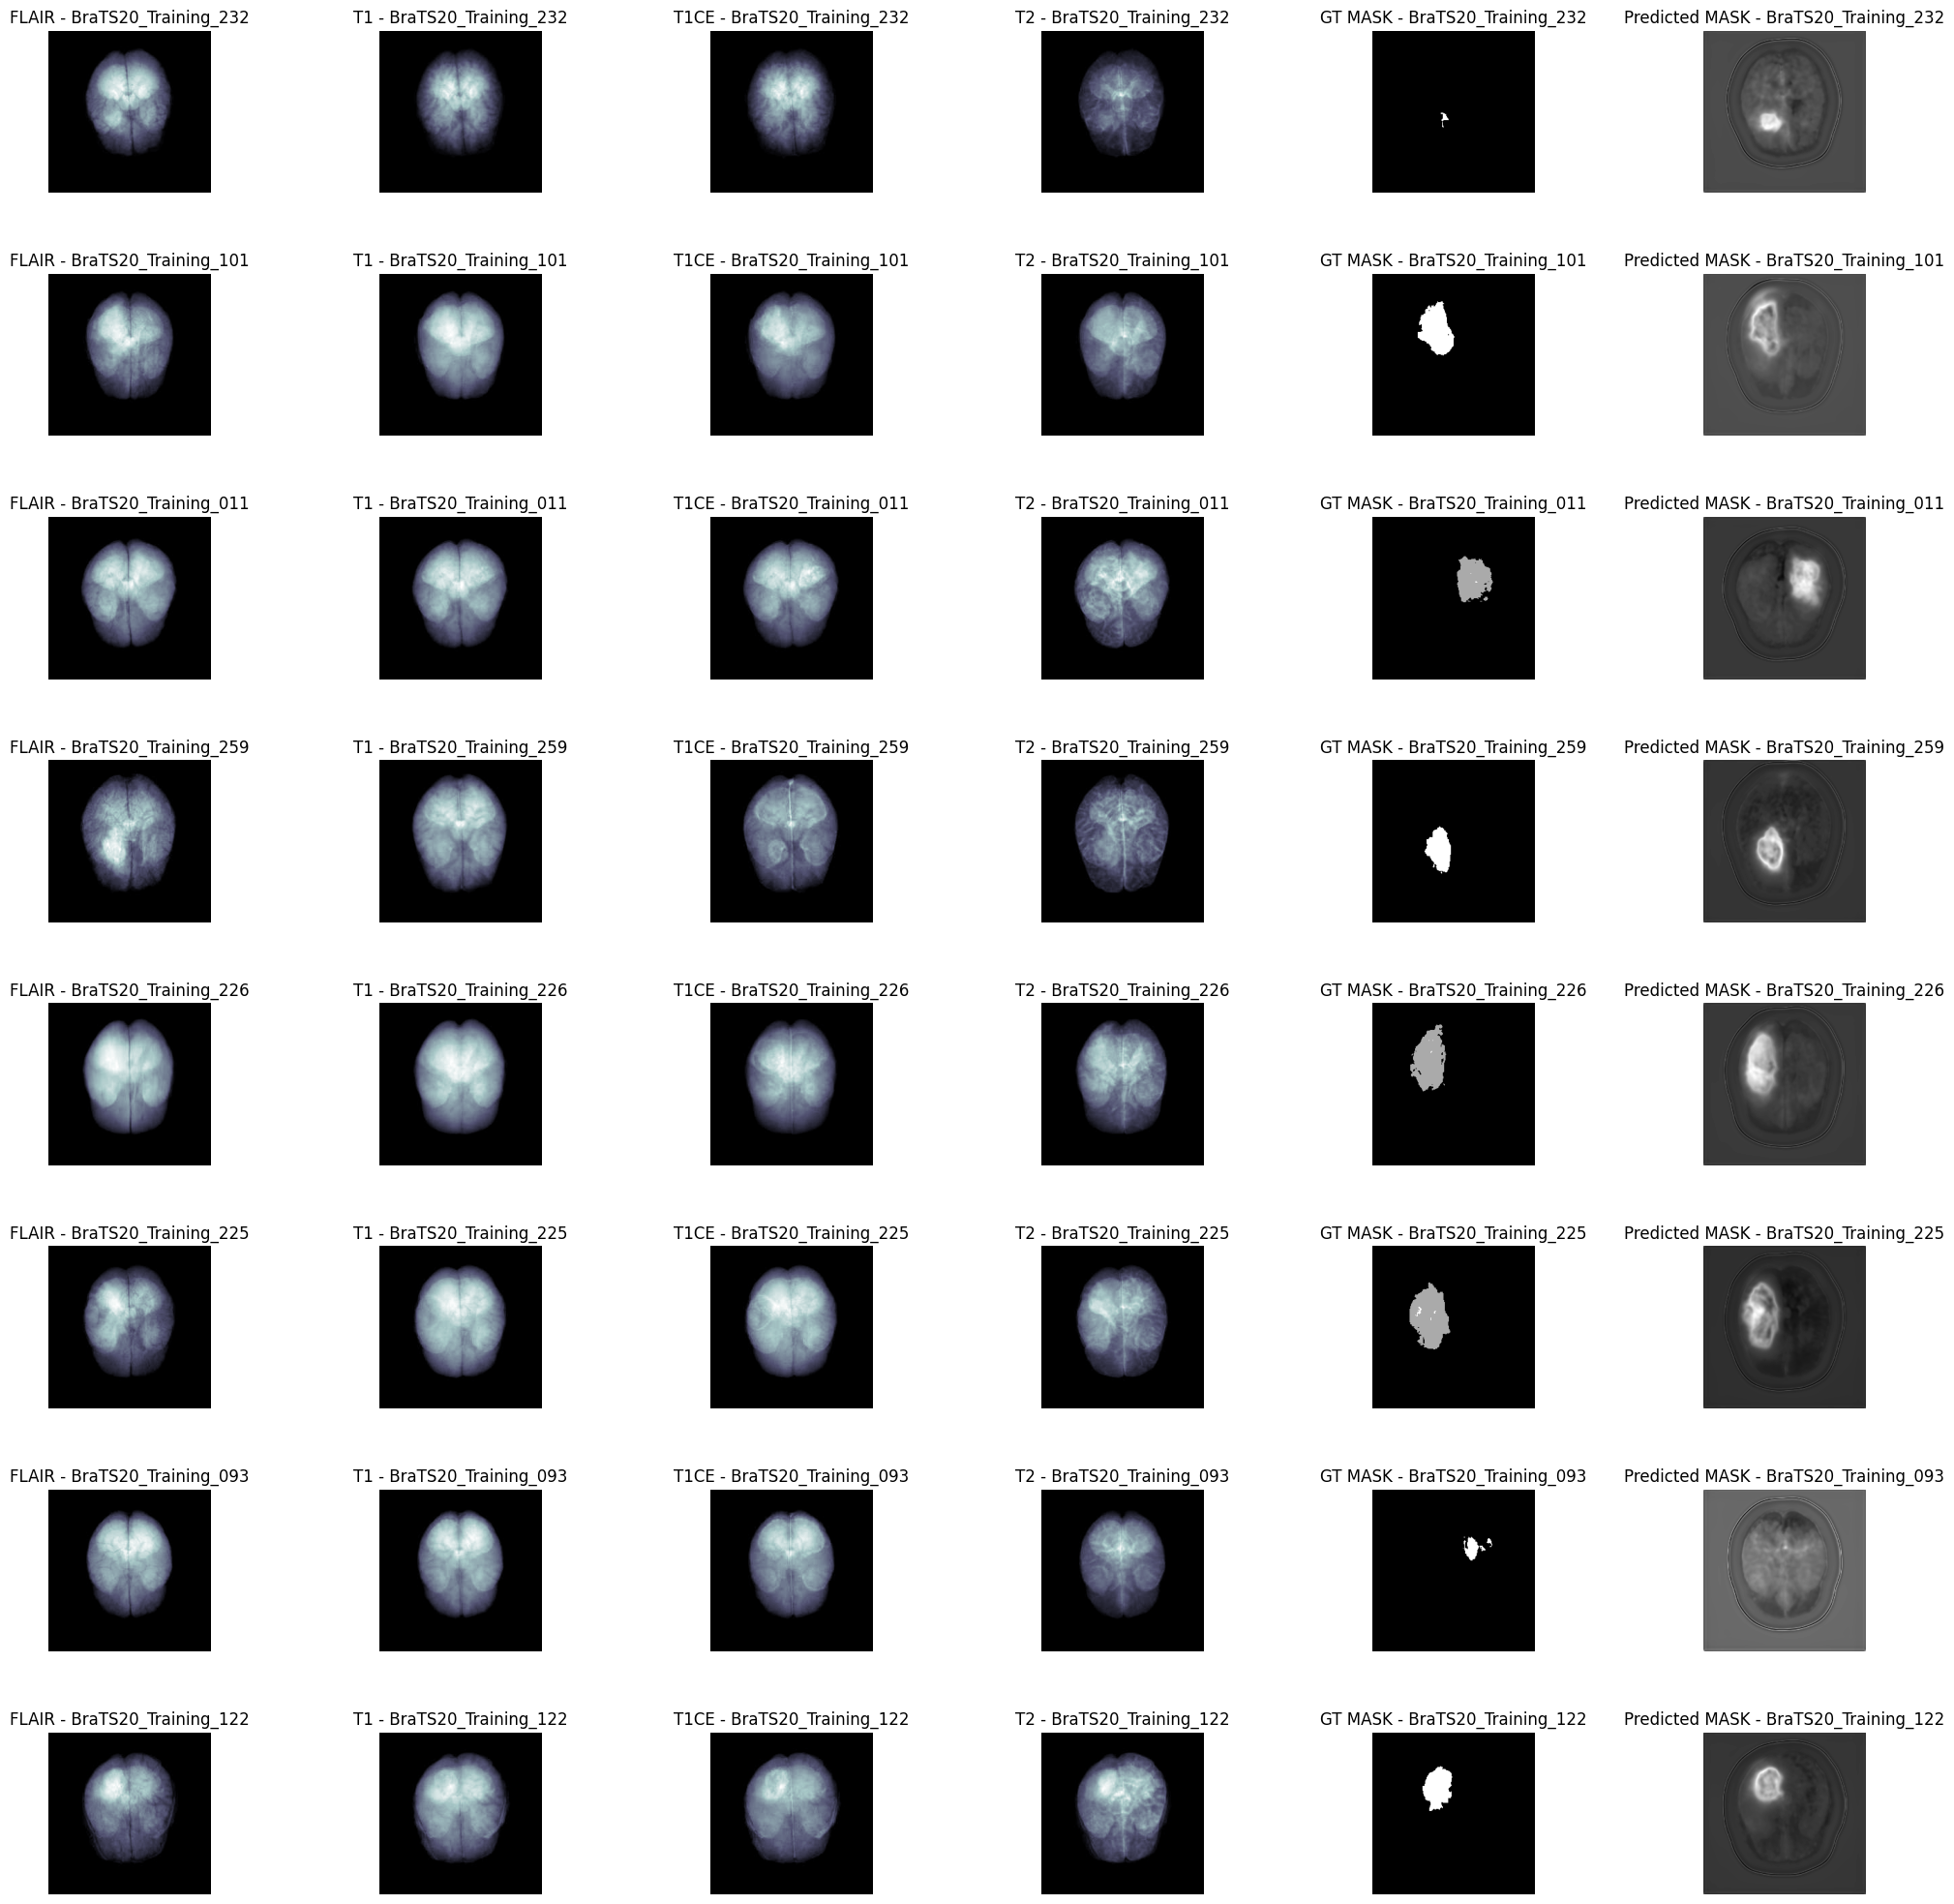

torch.Size([8, 4, 240, 240])
torch.Size([8, 4, 240, 240])


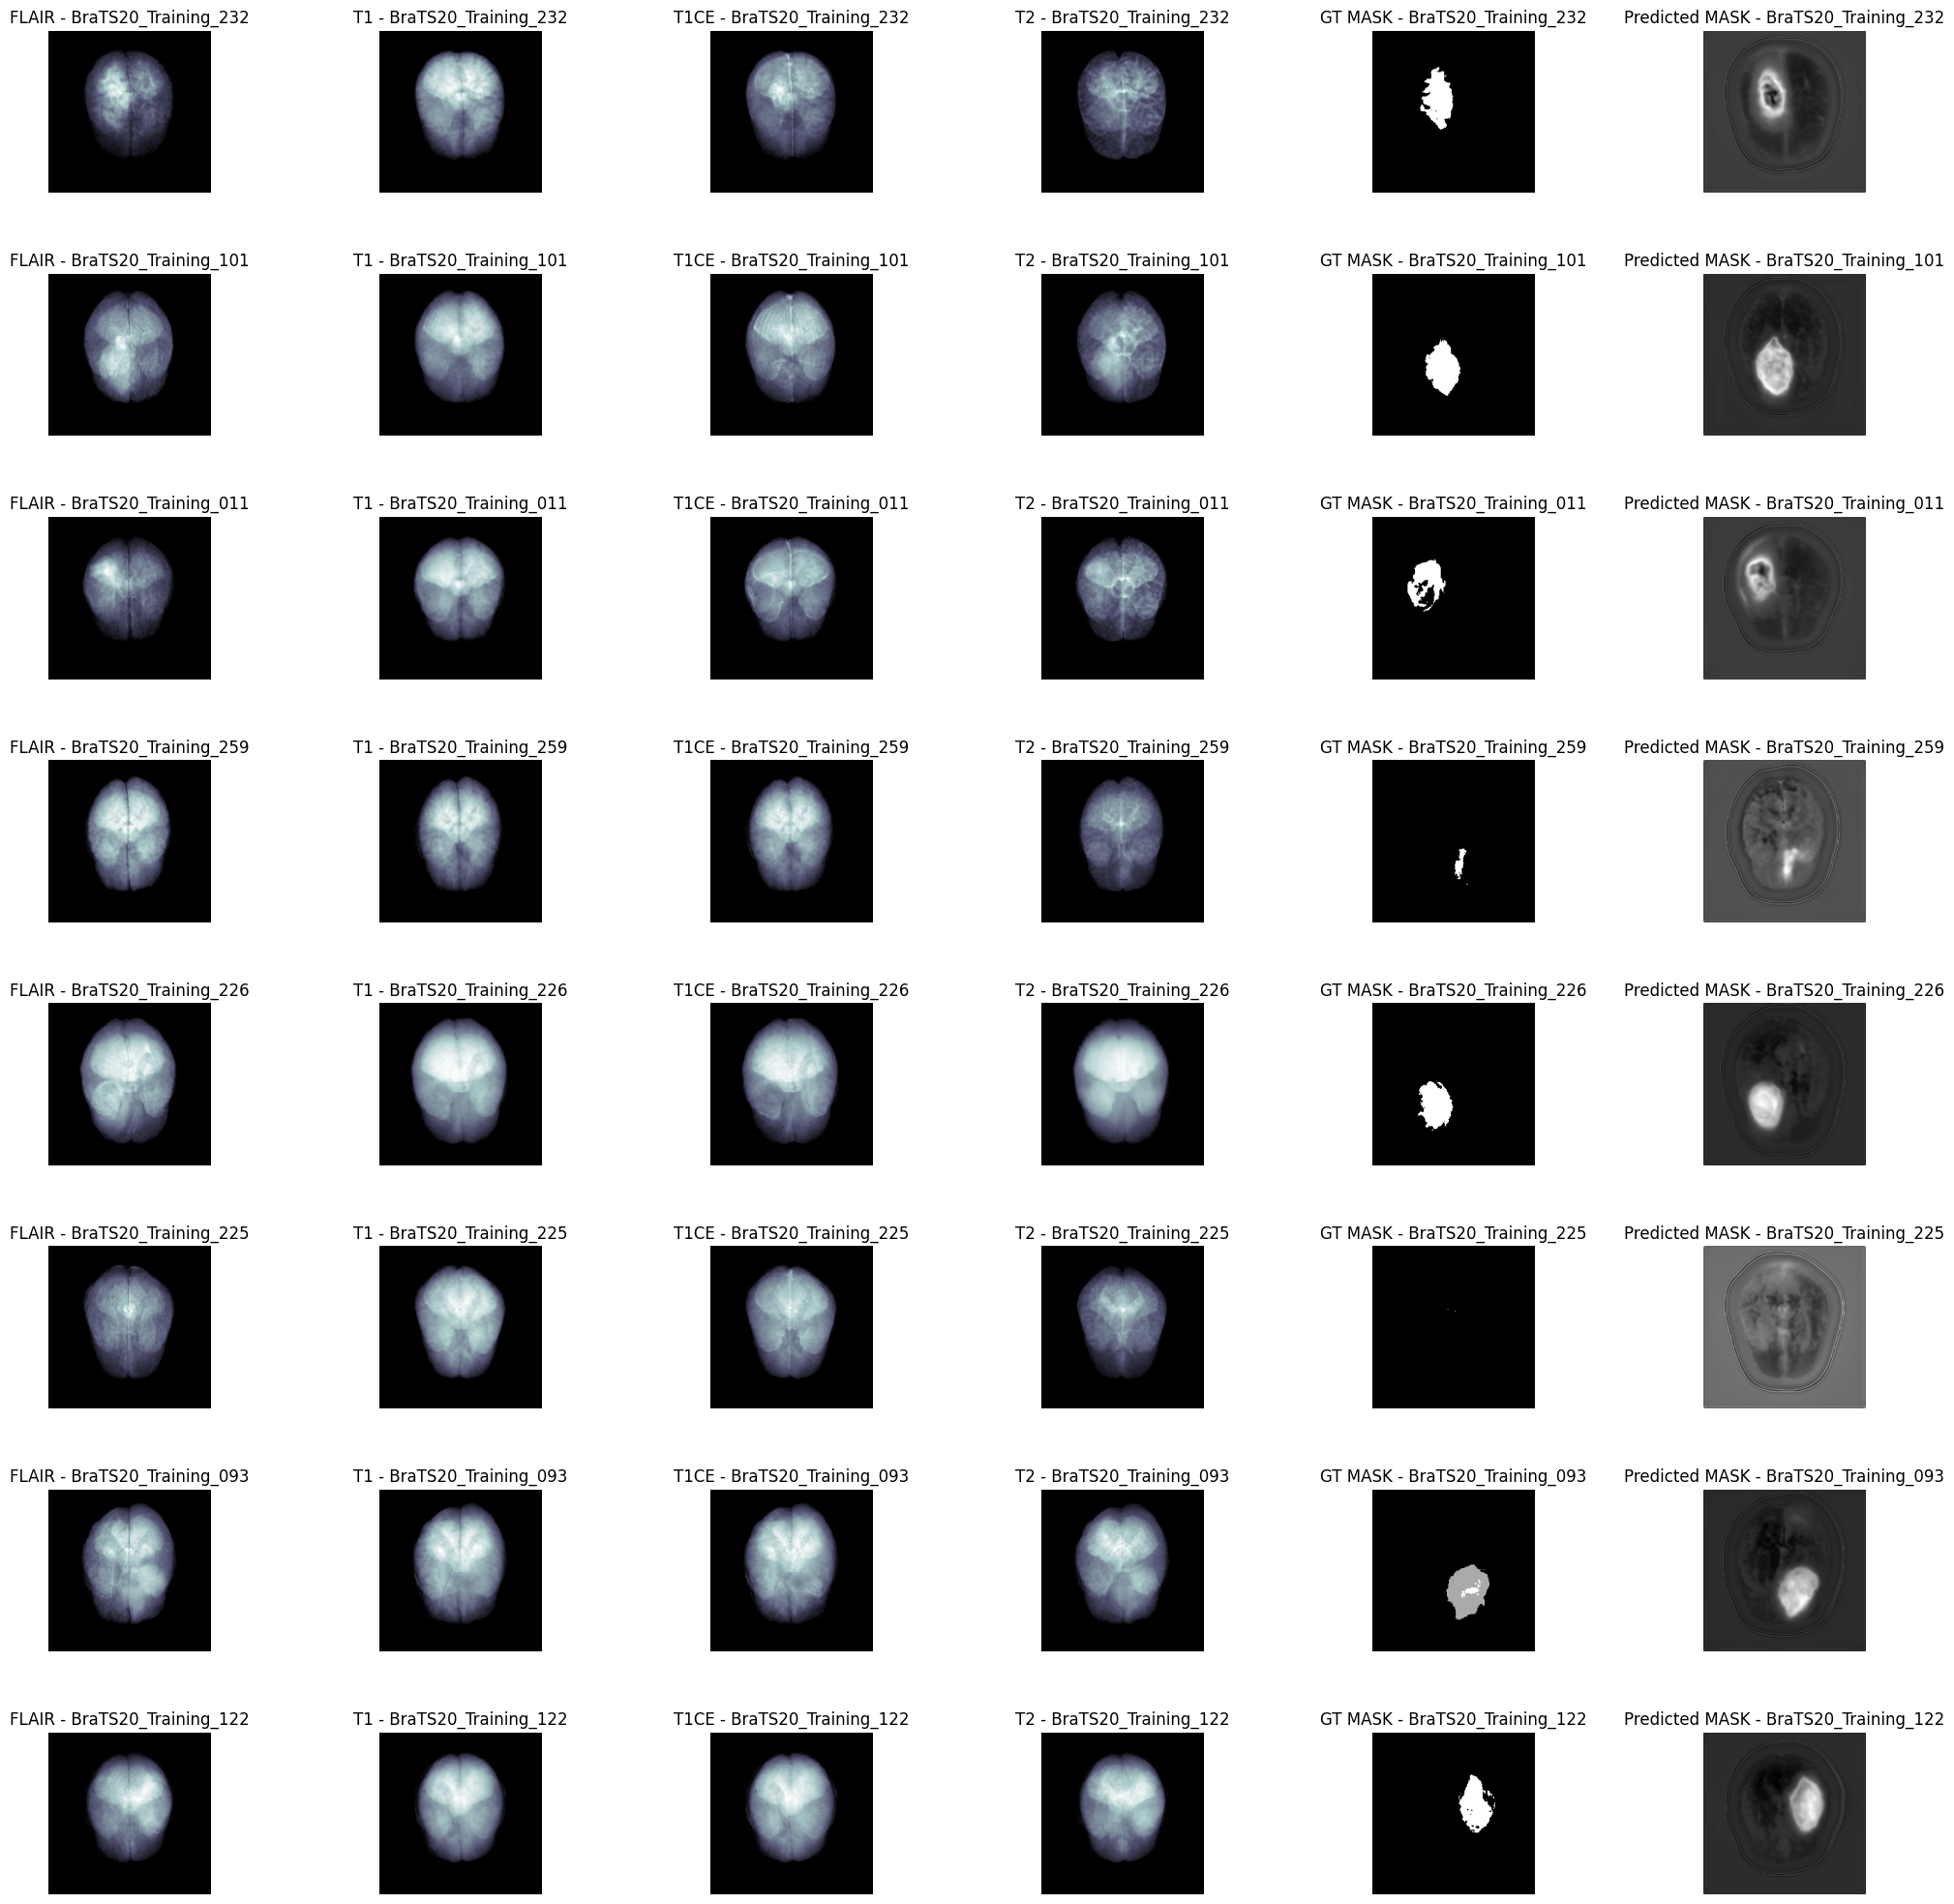

In [31]:
visualize_results(train_dl, model, modality_types, device)